# Intelligent Fuzzy Student Performance Prediction System

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Q9e0ui0XnKmplZ_2KETsCZYt4KRzCK6h)


## Project Overview
This notebook implements a comprehensive machine learning pipeline using fuzzy logic for student academic performance prediction. The system combines exploratory data analysis, genetic algorithm-based feature selection, fuzzy inference systems, and interactive visualization to predict student outcomes (Dropout, Enrolled, Graduate).

## Contributors
- Abolfazl Ranjbar - [GitHub](https://github.com/ImRanjbar)
- Miaad Kimiagari - [GitHub](https://github.com/Miaad2004)
- Taha Najaf - [GitHub](https://github.com/taha-najaf)

## System Architecture
- **Data Preprocessing**: Feature engineering, outlier handling, and SMOTE-based class balancing
- **Feature Selection**: Mutual information analysis with multicollinearity detection
- **Fuzzification**: Triangular membership functions for continuous and binary features
- **Rule Extraction**: Wang-Mendel algorithm for fuzzy rule generation
- **Optimization**: Genetic algorithm for optimal rule subset selection
- **Inference Engine**: Fuzzy inference system with weighted rule activation
- **User Interface**: Interactive Gradio-based prediction interface

# Data Analysis and Fuzzy Inference Implementation

**Methodology**: Comprehensive exploratory data analysis following machine learning best practices with advanced preprocessing pipeline and statistical feature analysis.

## Data Loading & Preprocessing Pipeline

### Initial Data Exploration

In [1]:
!pip install -q gdown numba pygad imbalanced-learn gradio
!gdown 1jR8wL-zLhe_aOpxA28v2OBOrnRM9pOsS --quiet

# 📦 Core Python
import math
import time
import multiprocessing as mp
import random

# 📊 Data handling
import numpy as np
import pandas as pd

# 📈 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 📉 Statistics
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 🔍 Feature selection
from sklearn.feature_selection import mutual_info_classif

# 🧱 Preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    StandardScaler,
)

# 🧠 Models
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

# 🧪 Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# 🌐 Graph
import networkx as nx

# 🧬 Genetic algorithm
import pygad

# GUI
import gradio as gr

SEED = 2025
USE_SMOTE = True

random.seed(SEED)
np.random.seed(SEED)

df = pd.read_csv("/content/fuzzy_final_ds.csv")
df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 5.2 MB/s eta 0:00:00


Marital status  Application mode  Application order  Course  \
0               1                 8                  5       2   
1               1                 6                  1      11   
2               1                 1                  5       5   
3               1                 8                  2      15   
4               2                12                  1       3   

   Daytime/evening attendance  Previous qualification  Nacionality  \
0                           1                       1            1   
1                           1                       1            1   
2                           1                       1            1   
3                           1                       1            1   
4                           0                       1            1   

   Mother's qualification  Father's qualification  Mother's occupation  ...  \
0                      13                      10                    6  ...   
1                       1                       3                    4  ...   
2                      22                      27                   10  ...   
3                      23                      27                    6  ...   
4                      22                      28                   10  ...   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
0                                    0                                    0   
1                                    0                                    6   
2                                    0                                    6   
3                                    0                                    6   
4                                    0                                    6   

   Curricular units 2nd sem (evaluations)  \
0                                       0   
1                                       6   
2                                       0   
3                                      10   
4                                       6   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    0                          0.000000   
1                                    6                         13.666667   
2                                    0                          0.000000   
3                                    5                         12.400000   
4                                    6                         13.000000   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               10.8   
1                                               0               13.9   
2                                               0               10.8   
3                                               0                9.4   
4                                               0               13.9   

   Inflation rate   GDP    Target  
0             1.4  1.74   Dropout  
1            -0.3  0.79  Graduate  
2             1.4  1.74   Dropout  
3            -0.8 -3.12  Graduate  
4            -0.3  0.79  Graduate  

[5 rows x 35 columns]

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [3]:
df.describe()

Marital status  Application mode  Application order       Course  \
count     4424.000000       4424.000000        4424.000000  4424.000000   
mean         1.178571          6.886980           1.727848     9.899186   
std          0.605747          5.298964           1.313793     4.331792   
min          1.000000          1.000000           0.000000     1.000000   
25%          1.000000          1.000000           1.000000     6.000000   
50%          1.000000          8.000000           1.000000    10.000000   
75%          1.000000         12.000000           2.000000    13.000000   
max          6.000000         18.000000           9.000000    17.000000   

       Daytime/evening attendance  Previous qualification  Nacionality  \
count                 4424.000000             4424.000000  4424.000000   
mean                     0.890823                2.531420     1.254521   
std                      0.311897                3.963707     1.748447   
min                      0.000000                1.000000     1.000000   
25%                      1.000000                1.000000     1.000000   
50%                      1.000000                1.000000     1.000000   
75%                      1.000000                1.000000     1.000000   
max                      1.000000               17.000000    21.000000   

       Mother's qualification  Father's qualification  Mother's occupation  \
count             4424.000000             4424.000000          4424.000000   
mean                12.322107               16.455244             7.317812   
std                  9.026251               11.044800             3.997828   
min                  1.000000                1.000000             1.000000   
25%                  2.000000                3.000000             5.000000   
50%                 13.000000               14.000000             6.000000   
75%                 22.000000               27.000000            10.000000   
max                 29.000000               34.000000            32.000000   

       ...  Curricular units 1st sem (without evaluations)  \
count  ...                                     4424.000000   
mean   ...                                        0.137658   
std    ...                                        0.690880   
min    ...                                        0.000000   
25%    ...                                        0.000000   
50%    ...                                        0.000000   
75%    ...                                        0.000000   
max    ...                                       12.000000   

       Curricular units 2nd sem (credited)  \
count                          4424.000000   
mean                              0.541817   
std                               1.918546   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                              19.000000   

       Curricular units 2nd sem (enrolled)  \
count                          4424.000000   
mean                              6.232143   
std                               2.195951   
min                               0.000000   
25%                               5.000000   
50%                               6.000000   
75%                               7.000000   
max                              23.000000   

       Curricular units 2nd sem (evaluations)  \
count                             4424.000000   
mean                                 8.063291   
std                                  3.947951   
min                                  0.000000   
25%                                  6.000000   
50%                                  8.000000   
75%                                 10.000000   
max                                 33.000000   

       Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
count                          4424.000000        

In [4]:
df['Target'].value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

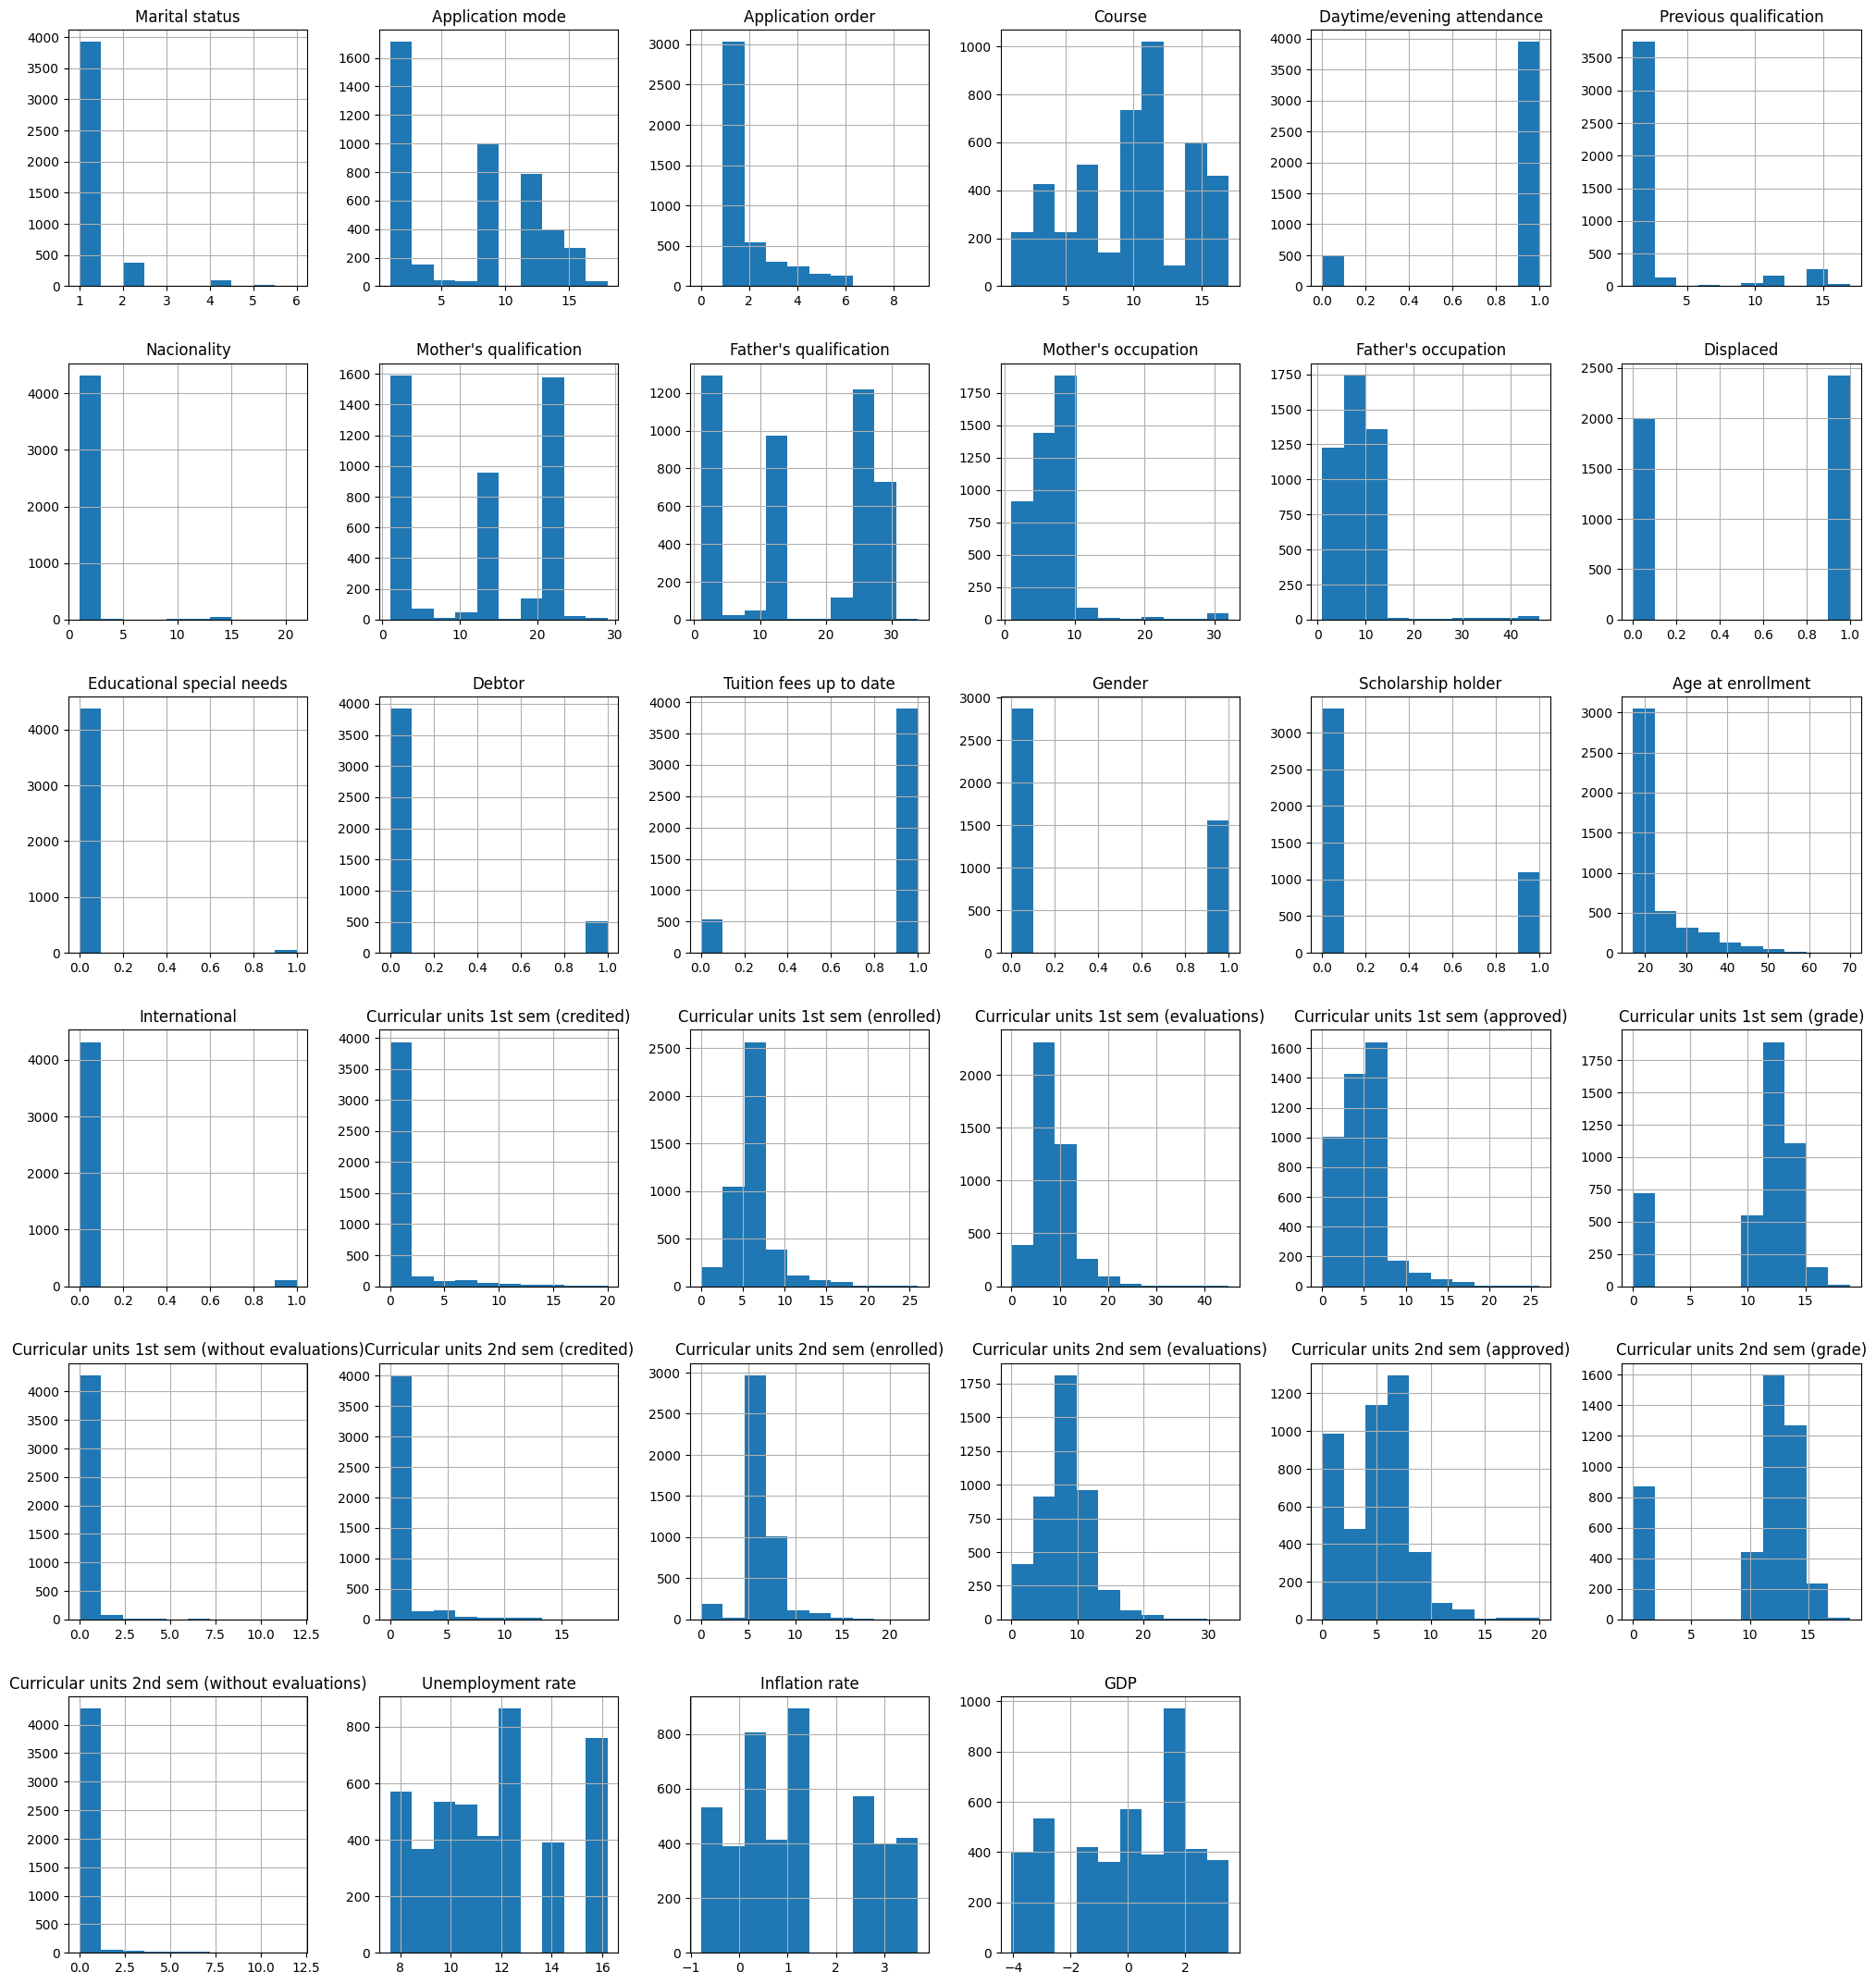

In [5]:
df.hist(figsize=(25,27))
plt.show()

### Data Partitioning (Stratified Split)

In [6]:
train_set, test_set = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    stratify=df["Target"]
)

### Feature Type Classification

In [7]:
cat_features = [
    "Marital status", "Application mode", "Course", "Daytime/evening attendance",
    "Previous qualification", "Nacionality", "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation", "Displaced", "Educational special needs",
    "Debtor", "Tuition fees up to date", "Gender", "Scholarship holder", "International", "Target"
]
numeric_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in cat_features]

### Statistical Distribution Analysis

In [8]:
numeric_cols = df[numeric_features]
skews = numeric_cols.apply(skew, bias=False)
high_skew = skews[skews.abs() > 0.7].index.tolist()
low_skew = [col for col in numeric_features if col not in high_skew]
print(skews)

Application order                                 1.881050
Age at enrollment                                 2.054988
Curricular units 1st sem (credited)               4.169049
Curricular units 1st sem (enrolled)               1.619041
Curricular units 1st sem (evaluations)            0.976637
Curricular units 1st sem (approved)               0.766262
Curricular units 1st sem (grade)                 -1.568146
Curricular units 1st sem (without evaluations)    8.207403
Curricular units 2nd sem (credited)               4.634820
Curricular units 2nd sem (enrolled)               0.788114
Curricular units 2nd sem (evaluations)            0.336497
Curricular units 2nd sem (approved)               0.306279
Curricular units 2nd sem (grade)                 -1.313650
Curricular units 2nd sem (without evaluations)    7.267701
Unemployment rate                                 0.212051
Inflation rate                                    0.252375
GDP                                              -0.3940

### Advanced Feature Engineering

In [9]:
engineered_features = [
    "approved_per_enrolled_1st_sem", "approved_per_enrolled_2nd_sem", "avg_approved_per_enrolled",
    "efficiency_grade_1st", "efficiency_grade_2nd", "tuition_impact", "scholarship_boost",
    "mother_qual_grade", "father_qual_grade", "age_efficiency",
    "total_approved", "total_enrolled", "global_approval_ratio", "eval_engagement"
]

def add_engineered_features(df):
    df = df.copy()
    df["approved_per_enrolled_1st_sem"] = df["Curricular units 1st sem (approved)"] / df["Curricular units 1st sem (enrolled)"]
    df["approved_per_enrolled_2nd_sem"] = df["Curricular units 2nd sem (approved)"] / df["Curricular units 2nd sem (enrolled)"]
    df['avg_approved_per_enrolled'] = (df["approved_per_enrolled_1st_sem"] + df["approved_per_enrolled_2nd_sem"]) / 2
    df['efficiency_grade_1st'] = df["approved_per_enrolled_1st_sem"] * df["Curricular units 1st sem (grade)"]
    df['efficiency_grade_2nd'] = df["approved_per_enrolled_2nd_sem"] * df["Curricular units 2nd sem (grade)"]
    df['tuition_impact'] = df["Tuition fees up to date"] * df["avg_approved_per_enrolled"]
    df['scholarship_boost'] = df["Scholarship holder"] * df["avg_approved_per_enrolled"]
    df['mother_qual_grade'] = df["Mother's qualification"] * df["avg_approved_per_enrolled"]
    df['father_qual_grade'] = df["Father's qualification"] * df["avg_approved_per_enrolled"]
    df['age_efficiency'] = df["Age at enrollment"] * df["avg_approved_per_enrolled"]
    df['total_approved'] = df["Curricular units 1st sem (approved)"] + df["Curricular units 2nd sem (approved)"]
    df['total_enrolled'] = df["Curricular units 1st sem (enrolled)"] + df["Curricular units 2nd sem (enrolled)"]
    df['global_approval_ratio'] = df["total_approved"] / df["total_enrolled"]
    df['eval_engagement'] = df["Curricular units 1st sem (evaluations)"] + df["Curricular units 2nd sem (evaluations)"]
    return df

feature_engineering_transformer = FunctionTransformer(add_engineered_features, validate=False)

### Statistical Outlier Detection & Removal

In [10]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.lower_bounds_ = None
        self.upper_bounds_ = None

    def fit(self, X, y=None):
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_bounds_ = Q1 - self.factor * IQR
        self.upper_bounds_ = Q3 + self.factor * IQR
        return self

    def transform(self, X):
        init_len = len(X)
        X_clipped = np.clip(X, self.lower_bounds_, self.upper_bounds_)
        print(f"n outliers removed: {init_len - len(X_clipped)}")
        return X_clipped


### Preprocessing Pipeline Architecture

In [11]:
low_skew += engineered_features

numeric_skew_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("clip_outliers", OutlierClipper(factor=1.5)),
    ("skew_fix", PowerTransformer(method="yeo-johnson", standardize=True)),
])


numeric_basic_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("clip_outliers", OutlierClipper(factor=1.5)),
    ("scaler", StandardScaler())
])


cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

target_pipeline = Pipeline([
    ("ordinal", OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ("num_skewed", numeric_skew_pipeline, high_skew),
    ("num_normal", numeric_basic_pipeline, low_skew),
    ("cat", cat_pipeline, cat_features),
    ("target", target_pipeline, ["Target_Ordinal"])
])

final_pipeline = Pipeline([
    ("feature_engineering", feature_engineering_transformer),
    ("preprocessing", preprocessor),
])

def preprocess_pipeline(df, is_test):
  df = df.copy()
  df["Target_Ordinal"] = df["Target"]


  if not is_test:
    processed = final_pipeline.fit_transform(df).toarray()

  if is_test:
    processed = final_pipeline.transform(df).toarray()

  ohe_feature_names = final_pipeline.named_steps["preprocessing"]\
      .named_transformers_["cat"]\
      .named_steps["onehot"]\
      .get_feature_names_out(cat_features)

  final_feature_names = list(high_skew) + list(low_skew) + list(ohe_feature_names) + ["Target_Ordinal"]
  df_out = pd.DataFrame(processed, columns=final_feature_names, index=df.index)

  target_cols = [col for col in df_out.columns if col.startswith("Target")]

  X = df_out.drop(target_cols, axis=1)
  Y = df_out[target_cols]

  return df_out, X, Y


train_set_processed, X_train, Y_train = preprocess_pipeline(train_set, is_test=False)
test_set_processed, X_test, Y_test = preprocess_pipeline(test_set, is_test=True)

n outliers removed: 0
n outliers removed: 0
n outliers removed: 0
n outliers removed: 0


### Class Imbalance Correction via SMOTE

In [12]:
from imblearn.over_sampling import SMOTE

if USE_SMOTE:
    smote = SMOTE(random_state=SEED)
    X_train, y_resampled = smote.fit_resample(X_train, Y_train["Target_Ordinal"])

    Y_train = pd.DataFrame({"Target_Ordinal": y_resampled}, index=np.arange(len(y_resampled)))

    train_set_processed = pd.concat([pd.DataFrame(X_train, index=Y_train.index), Y_train], axis=1)


### Post-Processing Visualizations

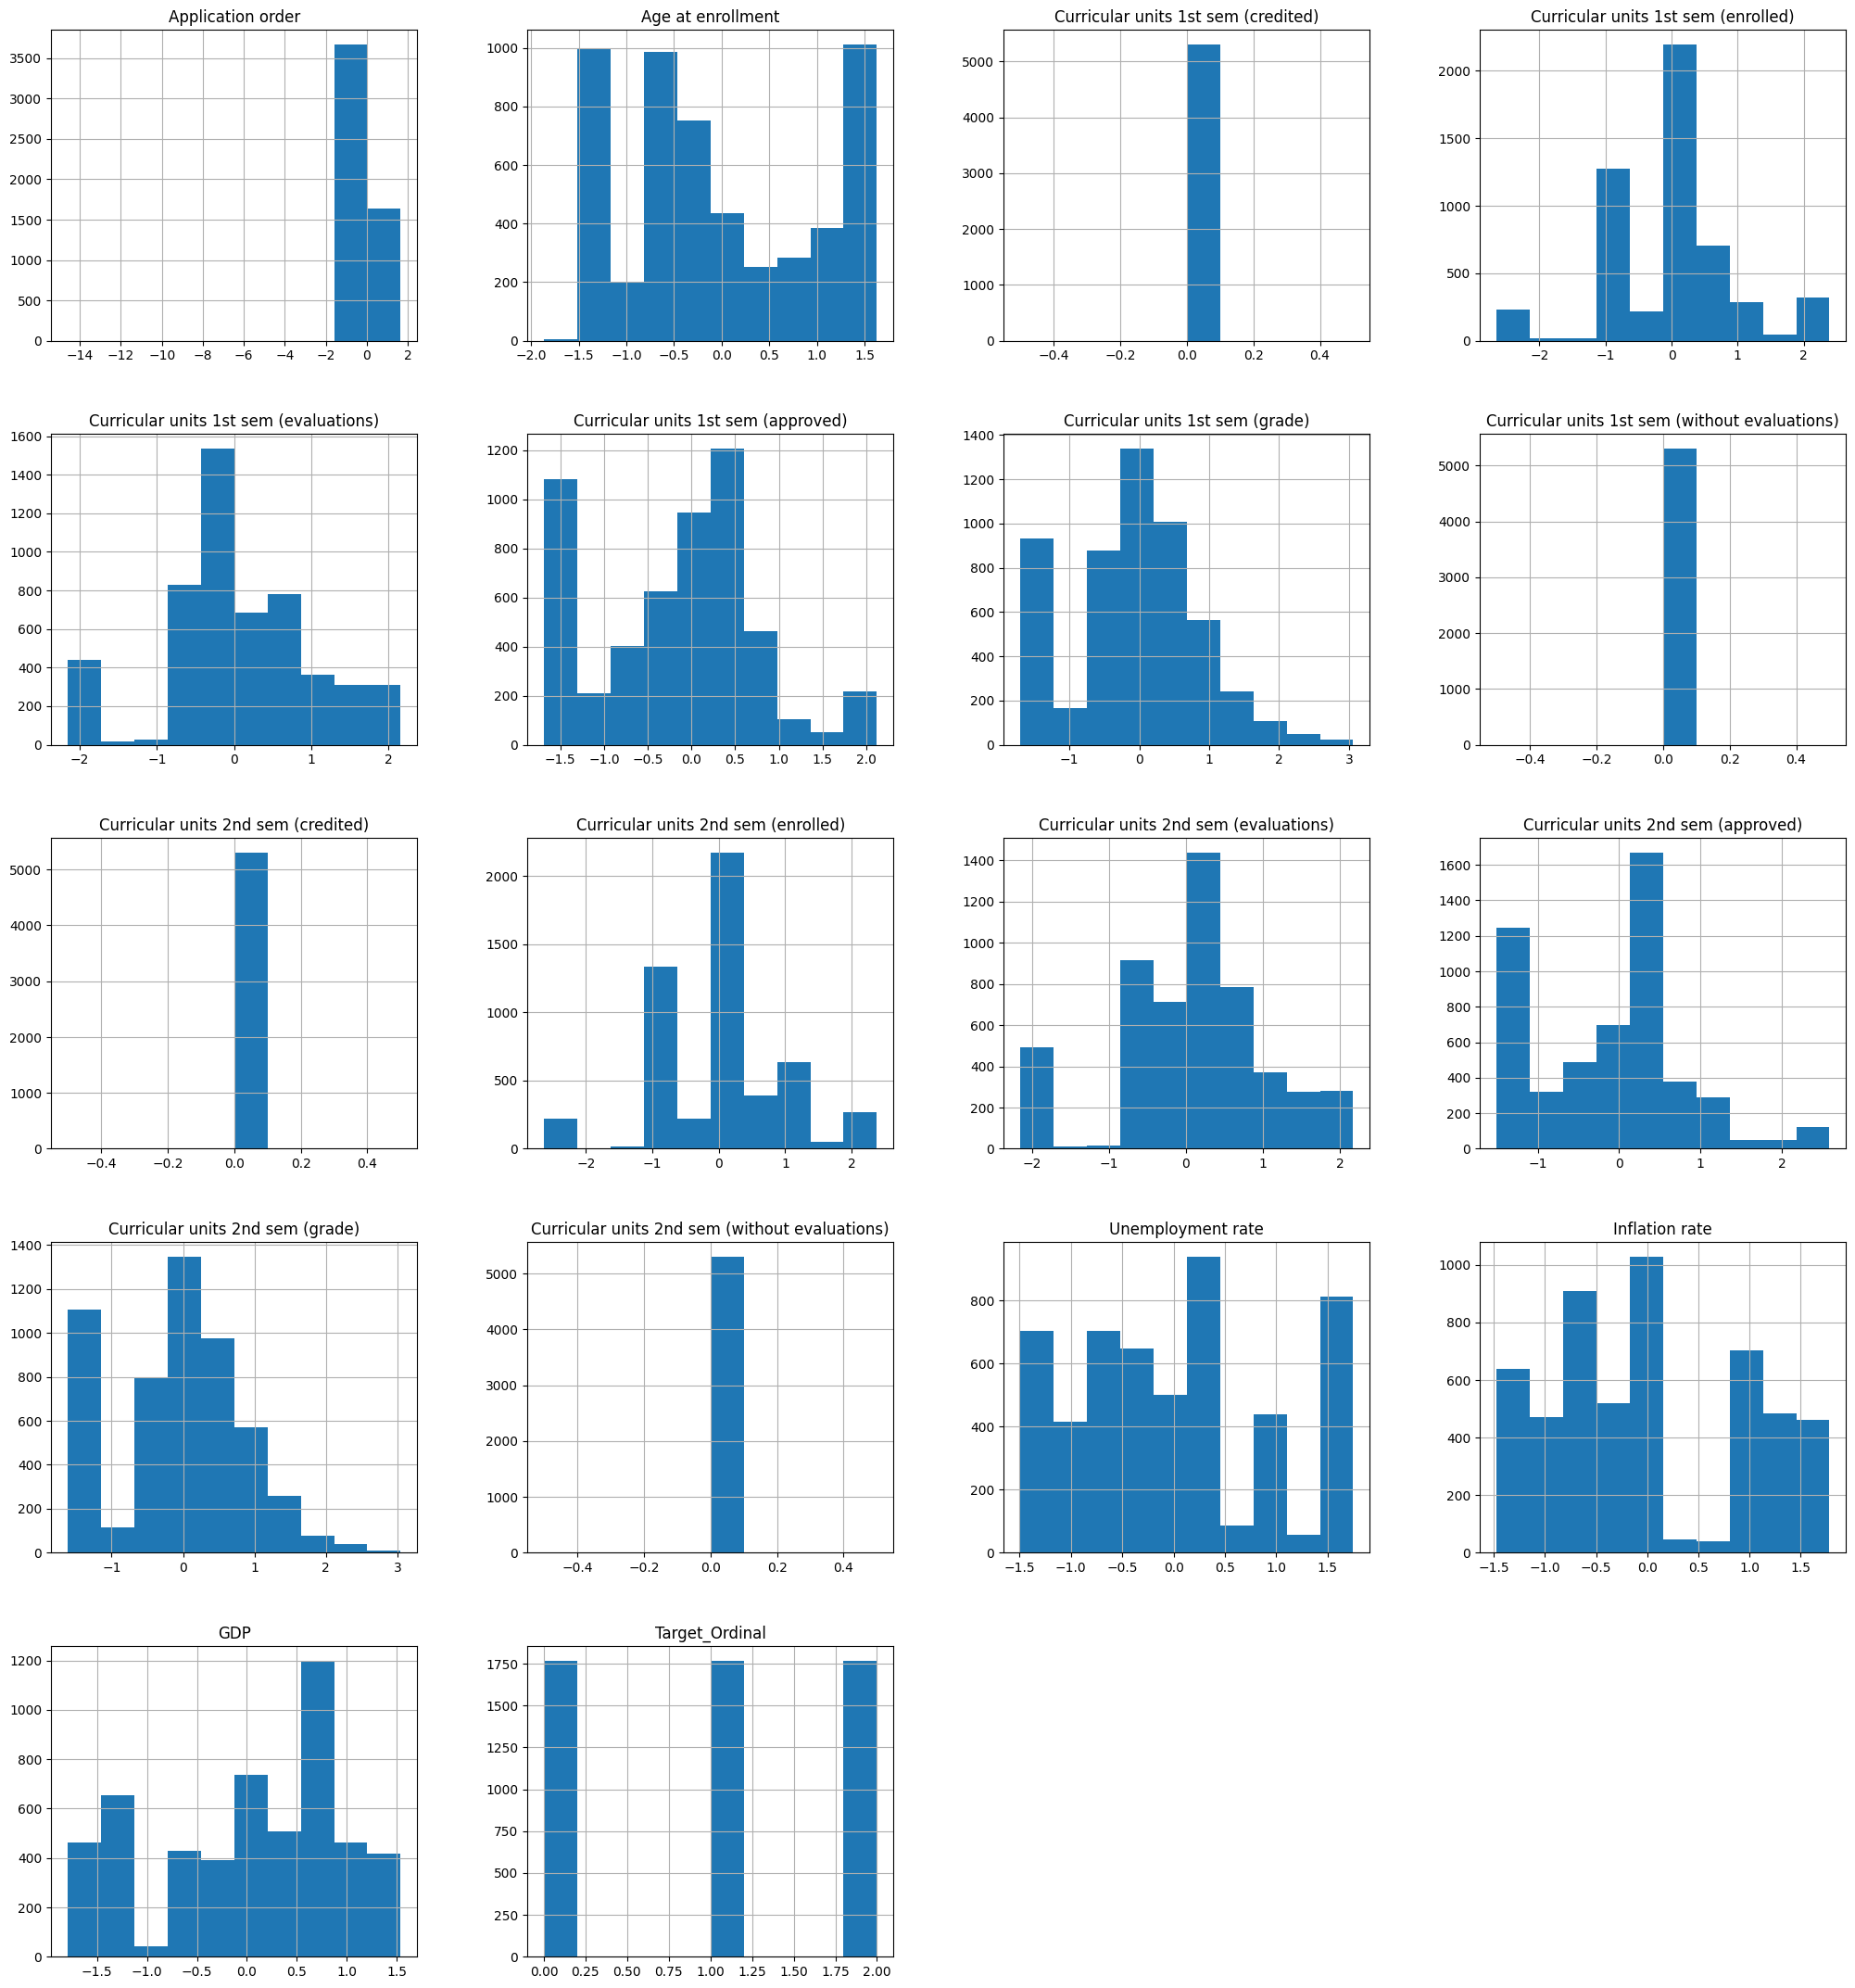

In [13]:
train_set_processed[numeric_features + ["Target_Ordinal"]].hist(figsize=(25,27))
plt.show()

### Intelligent Feature Selection

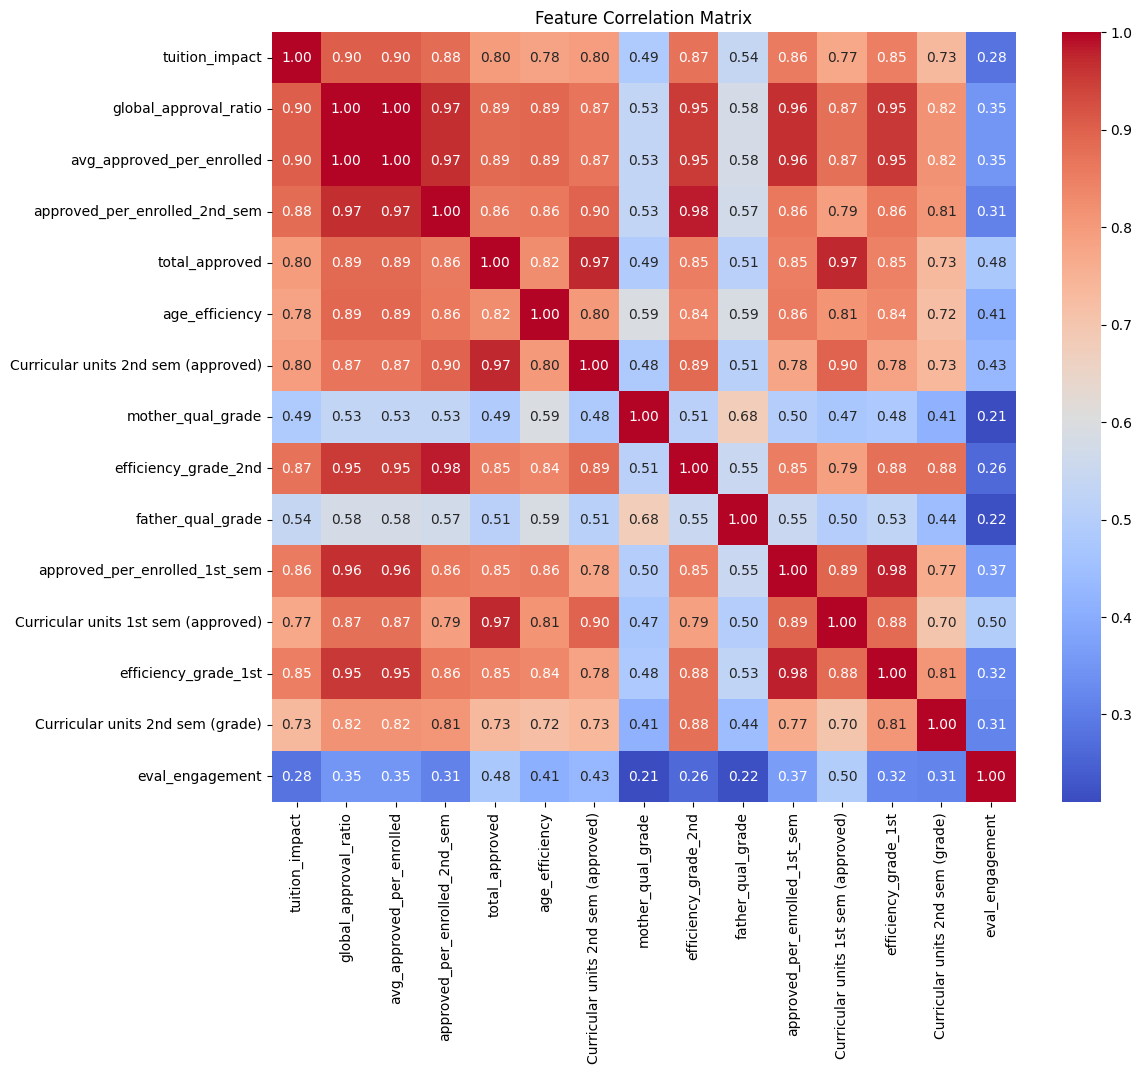

In [14]:
X_clean = train_set_processed.drop("Target_Ordinal", axis=1)
y_encoded = train_set_processed["Target_Ordinal"]

# find the top 15 features based on mi
mi = mutual_info_classif(X_clean, y_encoded, discrete_features='auto')
mi_series = pd.Series(mi, index=X_clean.columns).sort_values(ascending=False)
top_15_features = mi_series.head(15).to_dict()

# plot the corr mat
corr_matrix = train_set_processed[top_15_features.keys()].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")

plt.show()


In [15]:
class FeatureSelector:
  random_state = SEED

  @staticmethod
  def _calculate_vif(X_df):
      vif_data = pd.DataFrame()
      vif_data["feature"] = X_df.columns
      vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
      return vif_data

  @staticmethod
  def _find_mi(X_df, Y_df) -> pd.Series:
      mi = mutual_info_classif(X_df, Y_df, discrete_features='auto', random_state=FeatureSelector.random_state)
      mi_series = pd.Series(mi, index=X_df.columns).sort_values(ascending=False)

      return mi_series

  @staticmethod
  def _find_colinear_groups(df: pd.DataFrame, threshold=0.9):
      corr_matrix = df.corr().abs()
      upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

      G = nx.Graph()
      G.add_nodes_from(df.columns)

      for col in upper_triangle.columns:
          for row in upper_triangle.index:
              corr_value = upper_triangle.loc[row, col]
              if pd.notnull(corr_value) and corr_value > threshold:
                  G.add_edge(row, col)

      groups = list(nx.connected_components(G))

      return groups

  @staticmethod
  def _remove_colinears(feature_groups, mi_series: pd.Series):
    selected_features = []

    for group in feature_groups:
      group_mi = mi_series[list(group)]
      best_feature = group_mi.idxmax()
      selected_features.append((best_feature, mi_series[best_feature]))

    selcted_features_sorted = sorted(selected_features, key=lambda x: x[1], reverse=True)
    selected_features = [f[0] for f in selcted_features_sorted]

    return selected_features

  @staticmethod
  def get_top_features_dict(X_df, Y_df, top_n=15, verbose=True):
      mi_series = FeatureSelector._find_mi(X_df, Y_df)
      groups = FeatureSelector._find_colinear_groups(X_df)
      selected_features = FeatureSelector._remove_colinears(groups, mi_series)
      top_features = selected_features[:top_n]

      # For verbose
      log_df = pd.DataFrame()
      log_df['feature'] = top_features

      vif_df = FeatureSelector._calculate_vif(X_df[top_features])
      log_df = log_df.merge(vif_df, on="feature", how="left")

      log_df['mi'] = log_df['feature'].map(mi_series)

      # corr with target
      corrs = X_df[top_features].apply(lambda x: x.corr(Y_df))
      log_df['corr'] = log_df['feature'].map(corrs)
      log_df = log_df.round(3)

      if verbose:
          print(log_df.to_string(index=True))

      return top_features, log_df



top_features, info = FeatureSelector.get_top_features_dict(X_train, Y_train["Target_Ordinal"], top_n=12)


                             feature     VIF     mi   corr
0                     tuition_impact   7.578  0.442  0.679
1                     total_approved  11.364  0.400  0.582
2                     age_efficiency   9.141  0.395  0.528
3                  mother_qual_grade   2.105  0.383  0.352
4                  father_qual_grade   2.139  0.376  0.392
5   Curricular units 2nd sem (grade)   3.836  0.276  0.562
6                    eval_engagement   1.582  0.239  0.068
7   Curricular units 1st sem (grade)   3.231  0.208  0.493
8                  Age at enrollment   2.217  0.173 -0.286
9                     total_enrolled   3.747  0.112  0.185
10         Tuition fees up to date_0   1.927  0.095 -0.375
11                               GDP   1.025  0.093  0.042


### Feature Correlation Analysis

### Multi-dimensional Feature Correlation Matrix

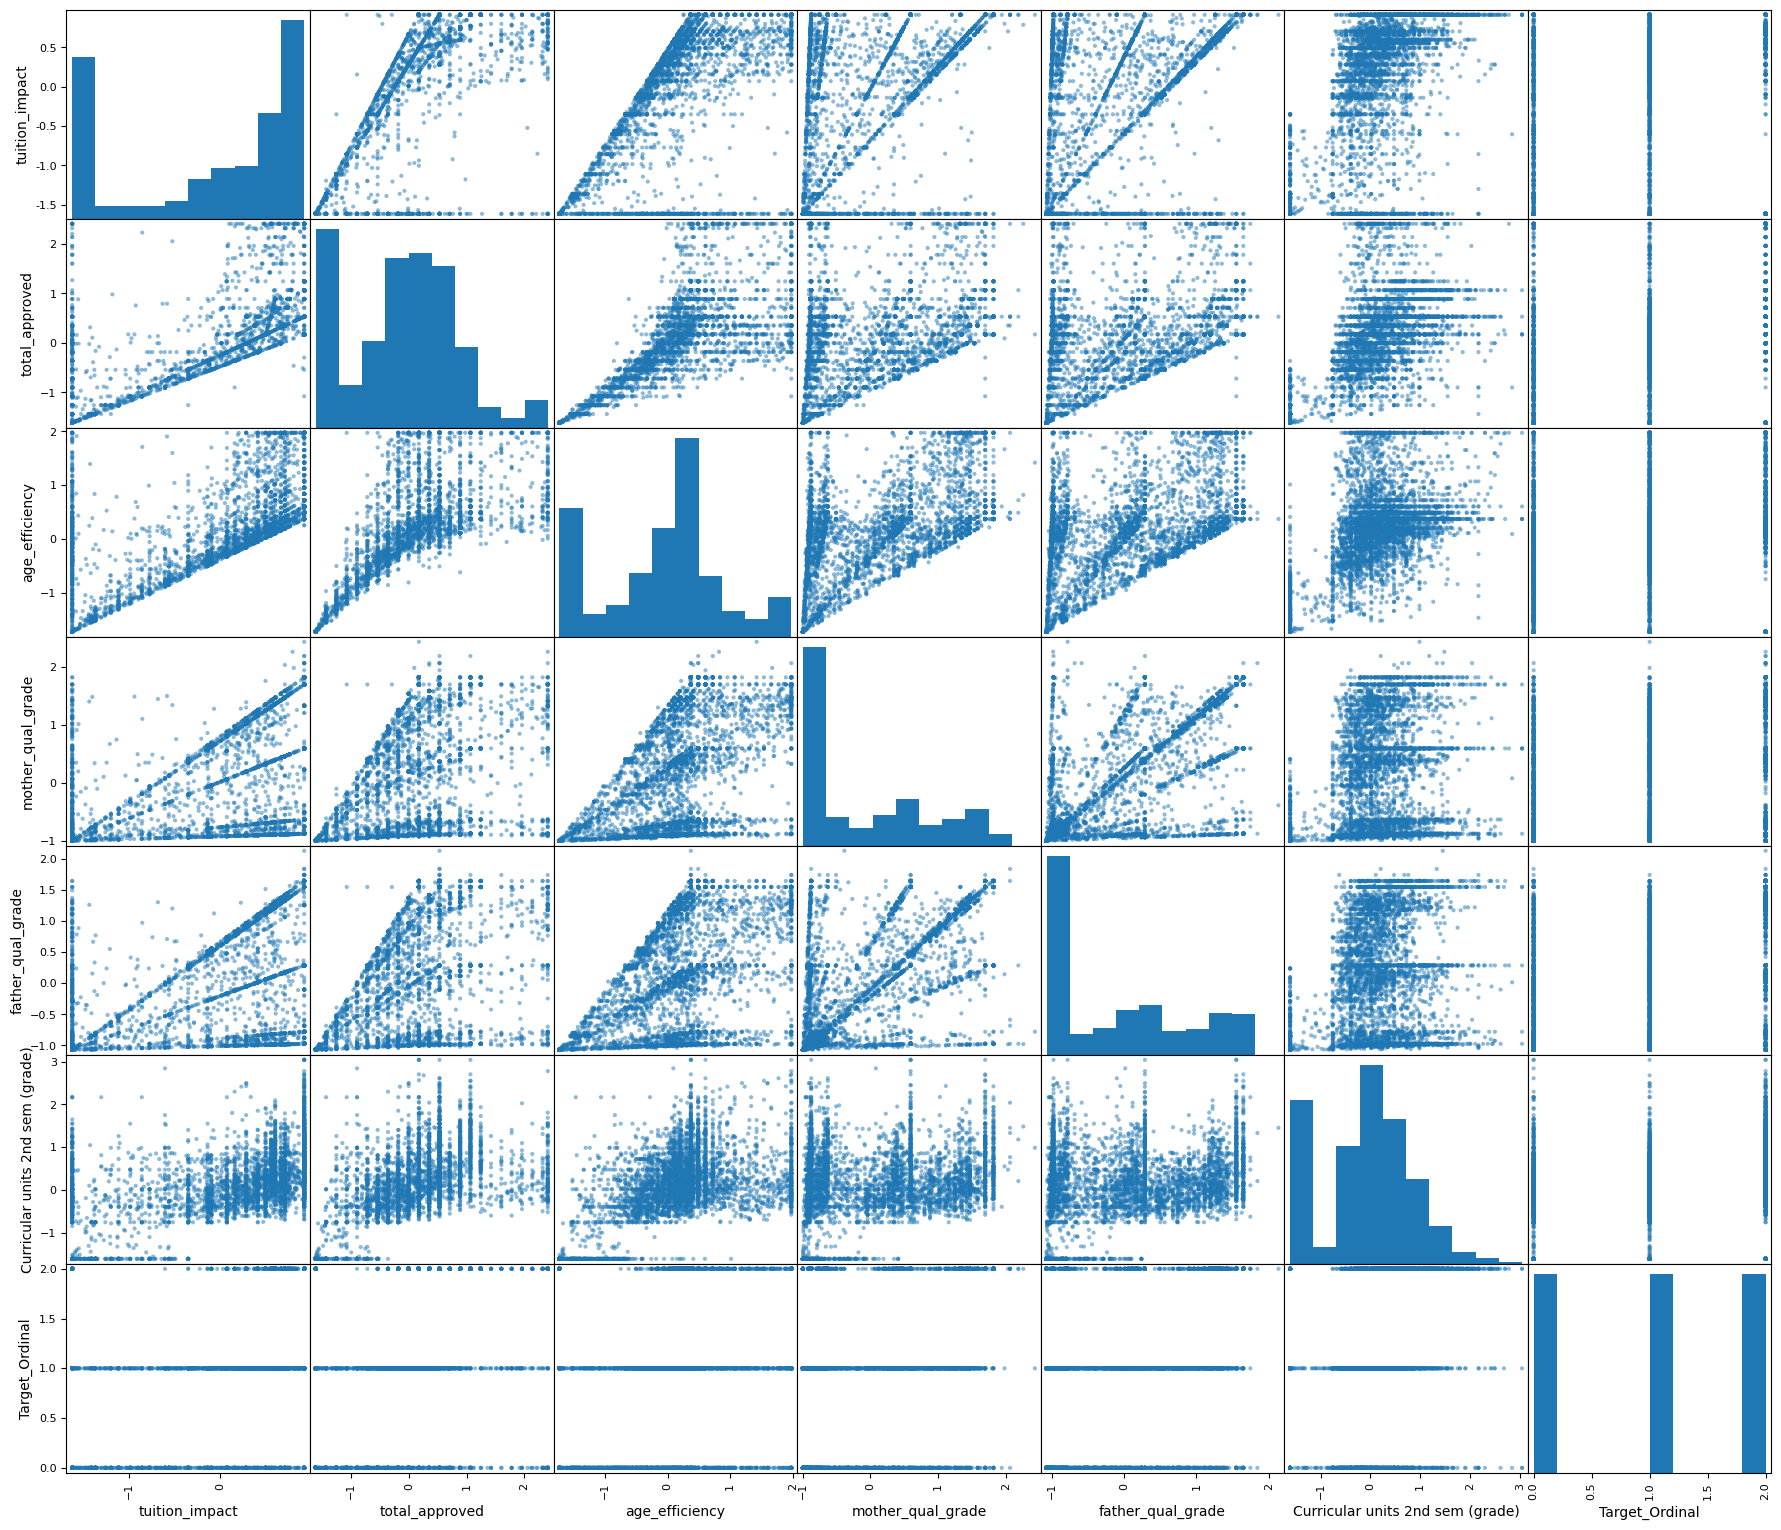

In [16]:
from pandas.plotting import scatter_matrix

scatter_matrix(train_set_processed[top_features[:6] + ["Target_Ordinal"]], figsize=(22, 19))
plt.show()

### Baseline Machine Learning Performance Evaluation

In [17]:
def evaluate_classifiers_from_split(X_train, X_test, y_train_df, y_test_df, target_col="Target_Ordinal"):
    models = {
        "Random (Stratified)": DummyClassifier(strategy="stratified", random_state=SEED),
        "Decision Tree": DecisionTreeClassifier(random_state=SEED),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
        "Support Vector Machine": SVC(kernel='rbf', C=1.0, gamma='scale', random_state=SEED),
        "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                                            max_iter=1000, early_stopping=True, random_state=SEED
        )
    }

    y_train = y_train_df[target_col]
    y_test = y_test_df[target_col]

    results = {}

    for name, model in models.items():
        print(f"\n=== {name} ===")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        matrix = confusion_matrix(y_test, y_pred)

        print(f"Accuracy: {acc:.4f}")
        print("\nClassification Report:\n", report)
        print("Confusion Matrix:\n", matrix)

        results[name] = {
            "accuracy": acc,
            "classification_report": report,
            "confusion_matrix": matrix
        }

    return results




results = evaluate_classifiers_from_split(X_train, X_test, Y_train, Y_test)



=== Random (Stratified) ===
Accuracy: 0.3311

Classification Report:
               precision    recall  f1-score   support

         0.0       0.31      0.32      0.31       284
         1.0       0.19      0.36      0.25       159
         2.0       0.51      0.33      0.40       442

    accuracy                           0.33       885
   macro avg       0.33      0.34      0.32       885
weighted avg       0.38      0.33      0.34       885

Confusion Matrix:
 [[ 91 100  93]
 [ 53  57  49]
 [153 144 145]]

=== Decision Tree ===
Accuracy: 0.7186

Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.77      0.74       284
         1.0       0.48      0.47      0.47       159
         2.0       0.81      0.78      0.79       442

    accuracy                           0.72       885
   macro avg       0.67      0.67      0.67       885
weighted avg       0.72      0.72      0.72       885

Confusion Matrix:
 [[219  25  40]
 [ 

## Fuzzy Logic Implementation

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

class Fuzzifier:
    def __init__(self, features: list[str]):
        self.features = features
        self.label_encoder = None
        self.min_max_values = None
        self.bin_feats = []
        self.cont_feats = []

    def fit(self, df: pd.DataFrame, target_col: str):
        """
        Fit the fuzzifier on the training data by computing the min and max values
        for each continuous feature.
        """
        self.label_encoder = LabelEncoder()
        self.y_true = self.label_encoder.fit_transform(df[target_col])
        self.min_max_values = self._get_min_max_for_continuous_features(df)
        self.bin_feats = [f for f in self.features if self.is_binary(df[f])]
        self.cont_feats = [f for f in self.features if not self.is_binary(df[f])]

    def transform(self, df: pd.DataFrame):
        memberships = pd.DataFrame(index=df.index)


        bin_feats = self.bin_feats
        cont_feats = self.cont_feats

        # Binary features (crisp-like)
        for B in bin_feats:
            memberships[f"{B}_is_1"] = (df[B] == 1).astype(float)
            memberships[f"{B}_is_0"] = (df[B] == 0).astype(float)
            memberships[f"{B}_fuzzy_label"] = np.where(
                memberships[f"{B}_is_1"] >= memberships[f"{B}_is_0"], '1', '0'
            )

        # Continuous features (triangular)
        for X in cont_feats:
            x = df[X].astype(float).to_numpy()
            m, M = self.min_max_values[X]

            if M == m:
                mu_low = np.zeros_like(x)
                mu_high = np.zeros_like(x)
                mu_med = np.ones_like(x)

            else:
                a = m
                b = (m + M) / 2
                c = M

                mu_low = self.triangular_mf(x, a=a, b=a, c=b)
                mu_med = self.triangular_mf(x, a=a, b=b, c=c)
                mu_high = self.triangular_mf(x, a=b, b=c, c=c)

            memberships[f"{X}_Low"] = mu_low
            memberships[f"{X}_Medium"] = mu_med
            memberships[f"{X}_High"] = mu_high

            cols = [f"{X}_{lbl}" for lbl in ["Low", "Medium", "High"]]
            memberships[f"{X}_fuzzy_label"] = (
                memberships[cols].idxmax(axis=1).str.replace(f"{X}_", "")
            )

          # for target


        return memberships

    def fit_transform(self, df: pd.DataFrame, target_col: str):
        self.fit(df, target_col)
        return self.transform(df)

    def _get_min_max_for_continuous_features(self, df: pd.DataFrame) -> dict:
        min_max_values = {}
        for feature in self.features:
            if not self.is_binary(df[feature]):
                min_max_values[feature] = (df[feature].min(), df[feature].max())

        return min_max_values

    @staticmethod
    def triangular_mf(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
        out = np.zeros_like(x, dtype=float)

        # For the rising edge
        rise = (x >= a) & (x < b)
        out[rise] = (x[rise] - a) / (b - a)

        # For the falling edge
        fall = (x >= b) & (x <= c)

        if b != c:
            out[fall] = (c - x[fall]) / (c - b)

        else:
            out[fall] = 1  # Handle the case where b == c by setting it to 1

        return out

    def is_binary(self, series: pd.Series) -> bool:
        """
        Check if a series is binary (0, 1 values).
        """
        return set(series.dropna().unique()) <= {0, 1}


In [19]:
fuzzifier = Fuzzifier(features=top_features + ["Target_Ordinal"])

fuzzifier.fit(train_set_processed, target_col="Target_Ordinal")

memberships_train = fuzzifier.transform(train_set_processed)
memberships_test = fuzzifier.transform(test_set_processed)

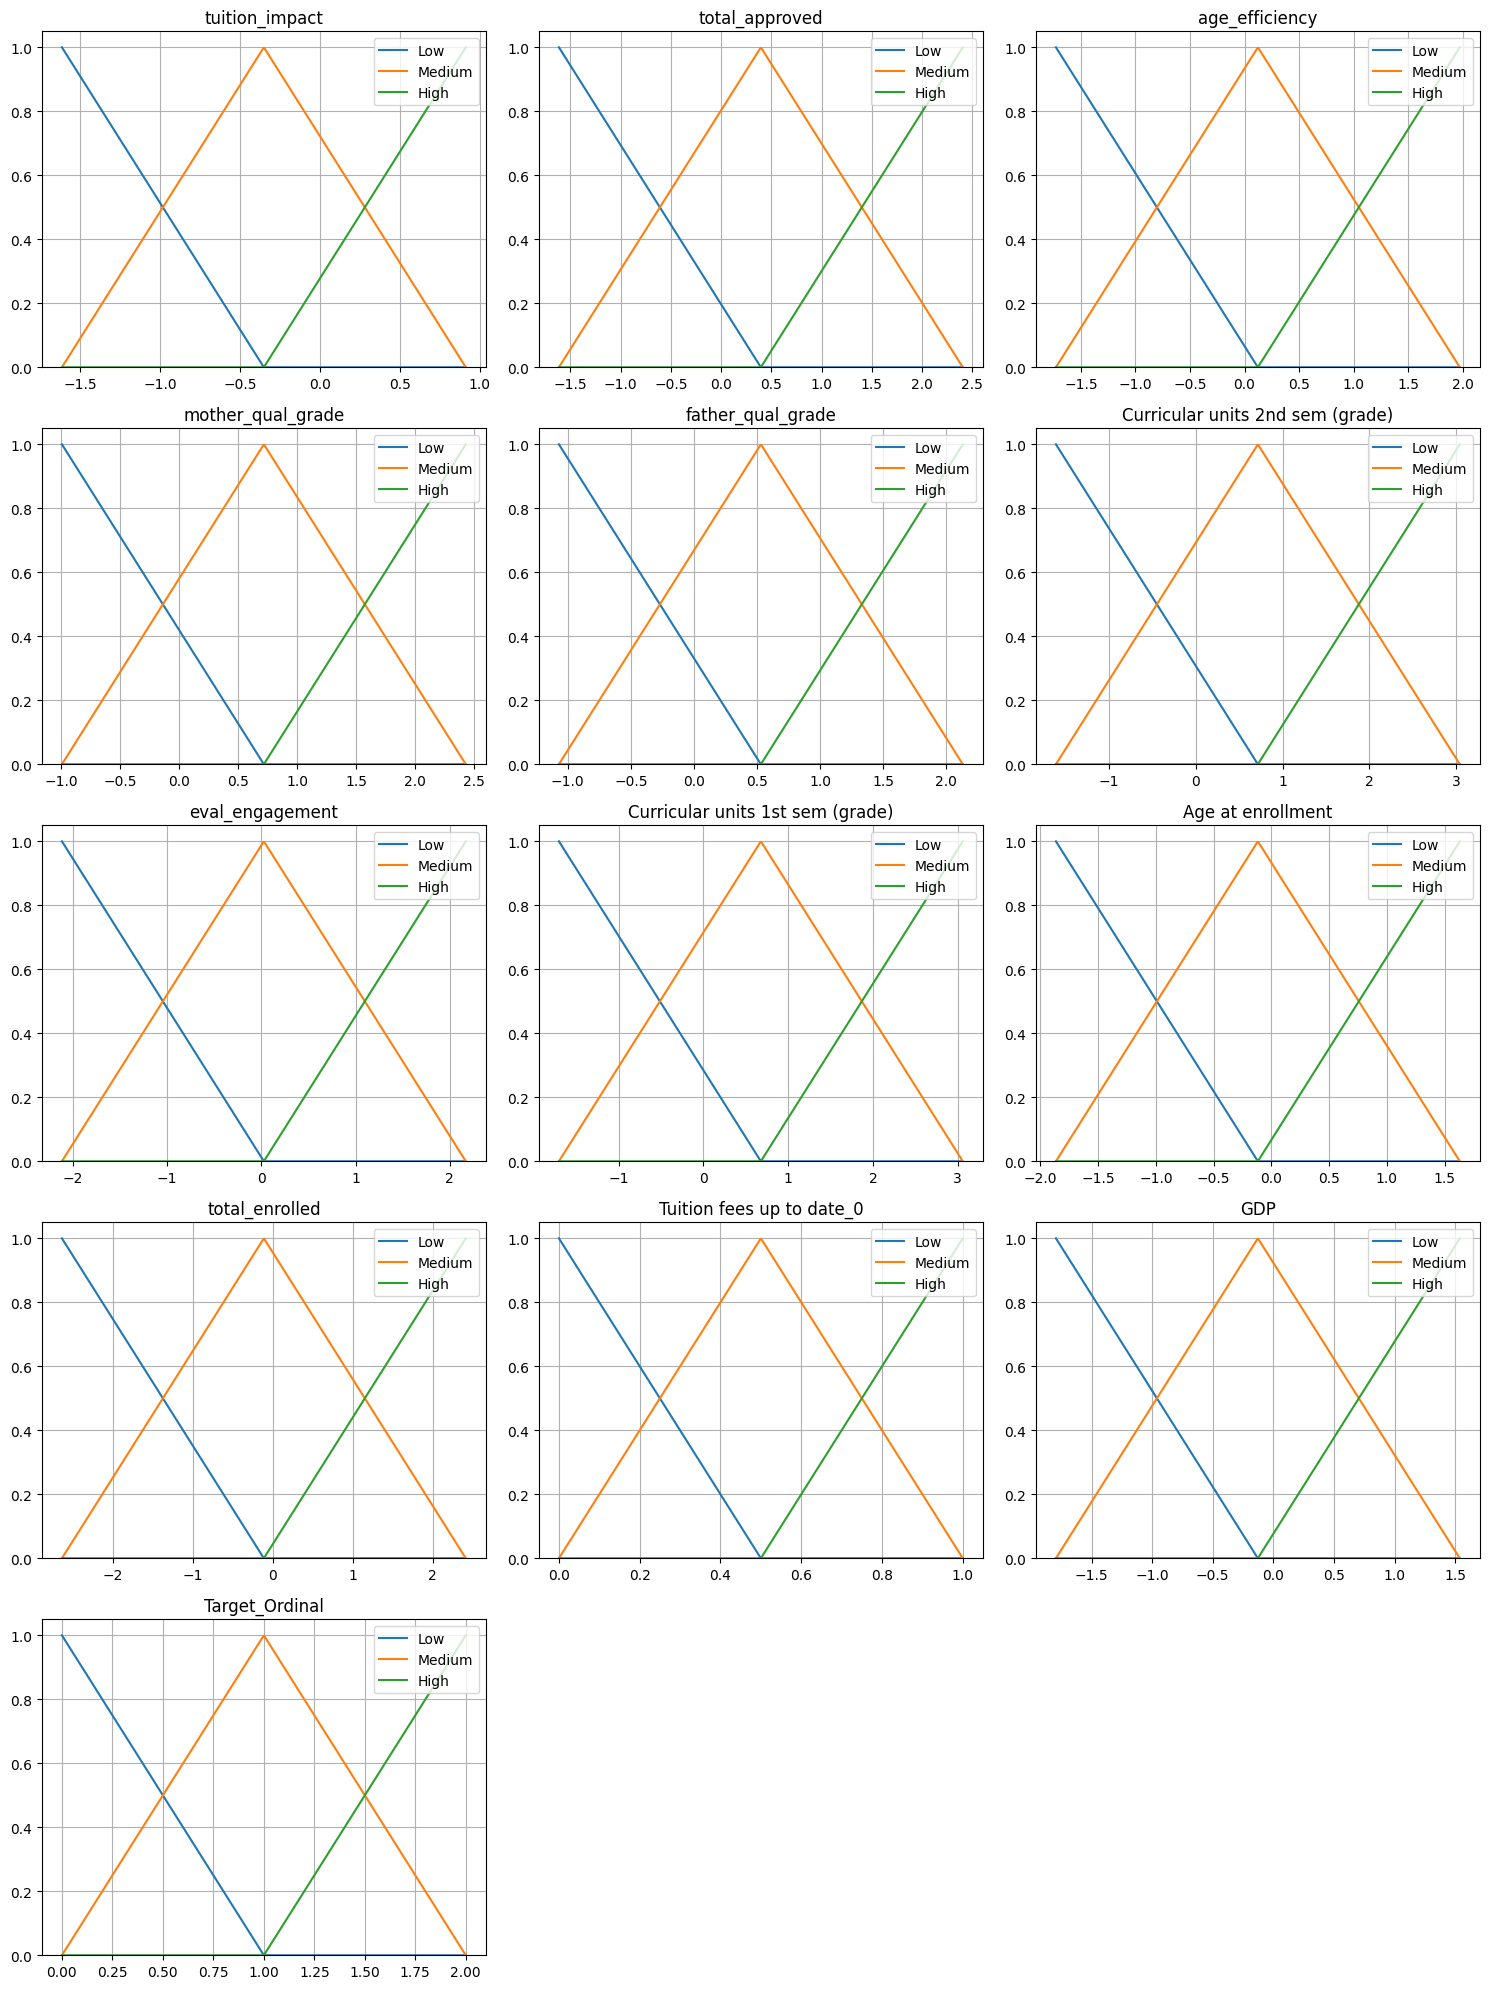

In [20]:
def plot_membership_grid(df, features, max_cols=3):
    n_feats = len(features)
    n_cols = min(n_feats, max_cols)
    n_rows = math.ceil(n_feats / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

    for idx, feat in enumerate(features):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]

        x = df[feat].astype(float)
        m, M = x.min(), x.max()

        if M == m:
            ax.set_title(f"{feat} (const)")
            ax.text(0.5, 0.5, "No variation", ha='center', va='center')
            ax.axis('off')
            continue

        a, b, c = m, (m + M) / 2, M
        x_vals = np.linspace(a, c, 500)
        mu_low = Fuzzifier.triangular_mf(x_vals, a=a, b=a, c=b)
        mu_med = Fuzzifier.triangular_mf(x_vals, a=a, b=b, c=c)
        mu_high = Fuzzifier.triangular_mf(x_vals, a=b, b=c, c=c)

        ax.plot(x_vals, mu_low, label="Low")
        ax.plot(x_vals, mu_med, label="Medium")
        ax.plot(x_vals, mu_high, label="High")

        ax.set_title(feat)
        ax.set_ylim(0, 1.05)
        ax.grid(True)
        ax.legend(loc='upper right')

    # Hide empty subplots
    for i in range(n_feats, n_rows * n_cols):
        row, col = divmod(i, n_cols)
        axes[row][col].axis('off')

    fig.tight_layout()
    plt.show()




plot_membership_grid(train_set_processed, top_features + ["Target_Ordinal"], max_cols=3)


In [21]:
memberships_train.describe()

tuition_impact_Low  tuition_impact_Medium  tuition_impact_High  \
count         5301.000000            5301.000000          5301.000000   
mean             0.275054               0.263722             0.461224   
std              0.426195               0.300219             0.402815   
min              0.000000               0.000000             0.000000   
25%              0.000000               0.000000             0.000000   
50%              0.000000               0.166667             0.500000   
75%              0.784617               0.468893             0.833333   
max              1.000000               1.000000             1.000000   

       total_approved_Low  total_approved_Medium  total_approved_High  \
count         5301.000000            5301.000000          5301.000000   
mean             0.338301               0.579872             0.081828   
std              0.373842               0.351238             0.197446   
min              0.000000               0.000000             0.000000   
25%              0.000000               0.266667             0.000000   
50%              0.200000               0.711111             0.000000   
75%              0.575519               0.888889             0.066667   
max              1.000000               0.999970             1.000000   

       age_efficiency_Low  age_efficiency_Medium  age_efficiency_High  \
count         5301.000000            5301.000000          5301.000000   
mean             0.263936               0.587381             0.148683   
std              0.380328               0.362447             0.255380   
min              0.000000               0.000000             0.000000   
25%              0.000000               0.227260             0.000000   
50%              0.003673               0.740157             0.000000   
75%              0.433071               0.868347             0.196850   
max              1.000000               0.999922             1.000000   

       mother_qual_grade_Low  ...  total_enrolled_High  \
count            5301.000000  ...          5301.000000   
mean                0.549739  ...             0.133827   
std                 0.419527  ...             0.263401   
min                 0.000000  ...             0.000000   
25%                 0.071429  ...             0.000000   
50%                 0.779786  ...             0.000000   
75%                 0.942857  ...             0.218193   
max                 1.000000  ...             1.000000   

       Tuition fees up to date_0_Low  Tuition fees up to date_0_Medium  \
count                    5301.000000                       5301.000000   
mean                        0.868139                          0.016889   
std                         0.334779                          0.105628   
min                         0.000000                          0.000000   
25%                         1.000000                          0.000000   
50%                         1.000000                          0.000000   
75%                         1.000000                          0.000000   
max                         1.000000                          0.999563   

       Tuition fees up to date_0_High      GDP_Low   GDP_Medium     GDP_High  \
count                     5301.000000  5301.000000  5301.000000  5301.000000   
mean                         0.114972     0.224417     0.473589     0.301995   
std                          0.314231     0.346050     0.283597     0.310238   
min                          0.000000     0.000000     0.000000     0.000000   
25%                          0.000000     0.000000     0.248349     0.000000   
50%                          0.000000     0.000000     0.467635     0.157199   
75%                          0.000000     0.376486     0.718626     0.545575   
max                          1.000000     1.000000     0.999012     1.000000   

       Target_Ordinal_Low  Target_Ordinal_Medium  Target_Ordinal_High  
count         5301.000000            5301.000000  

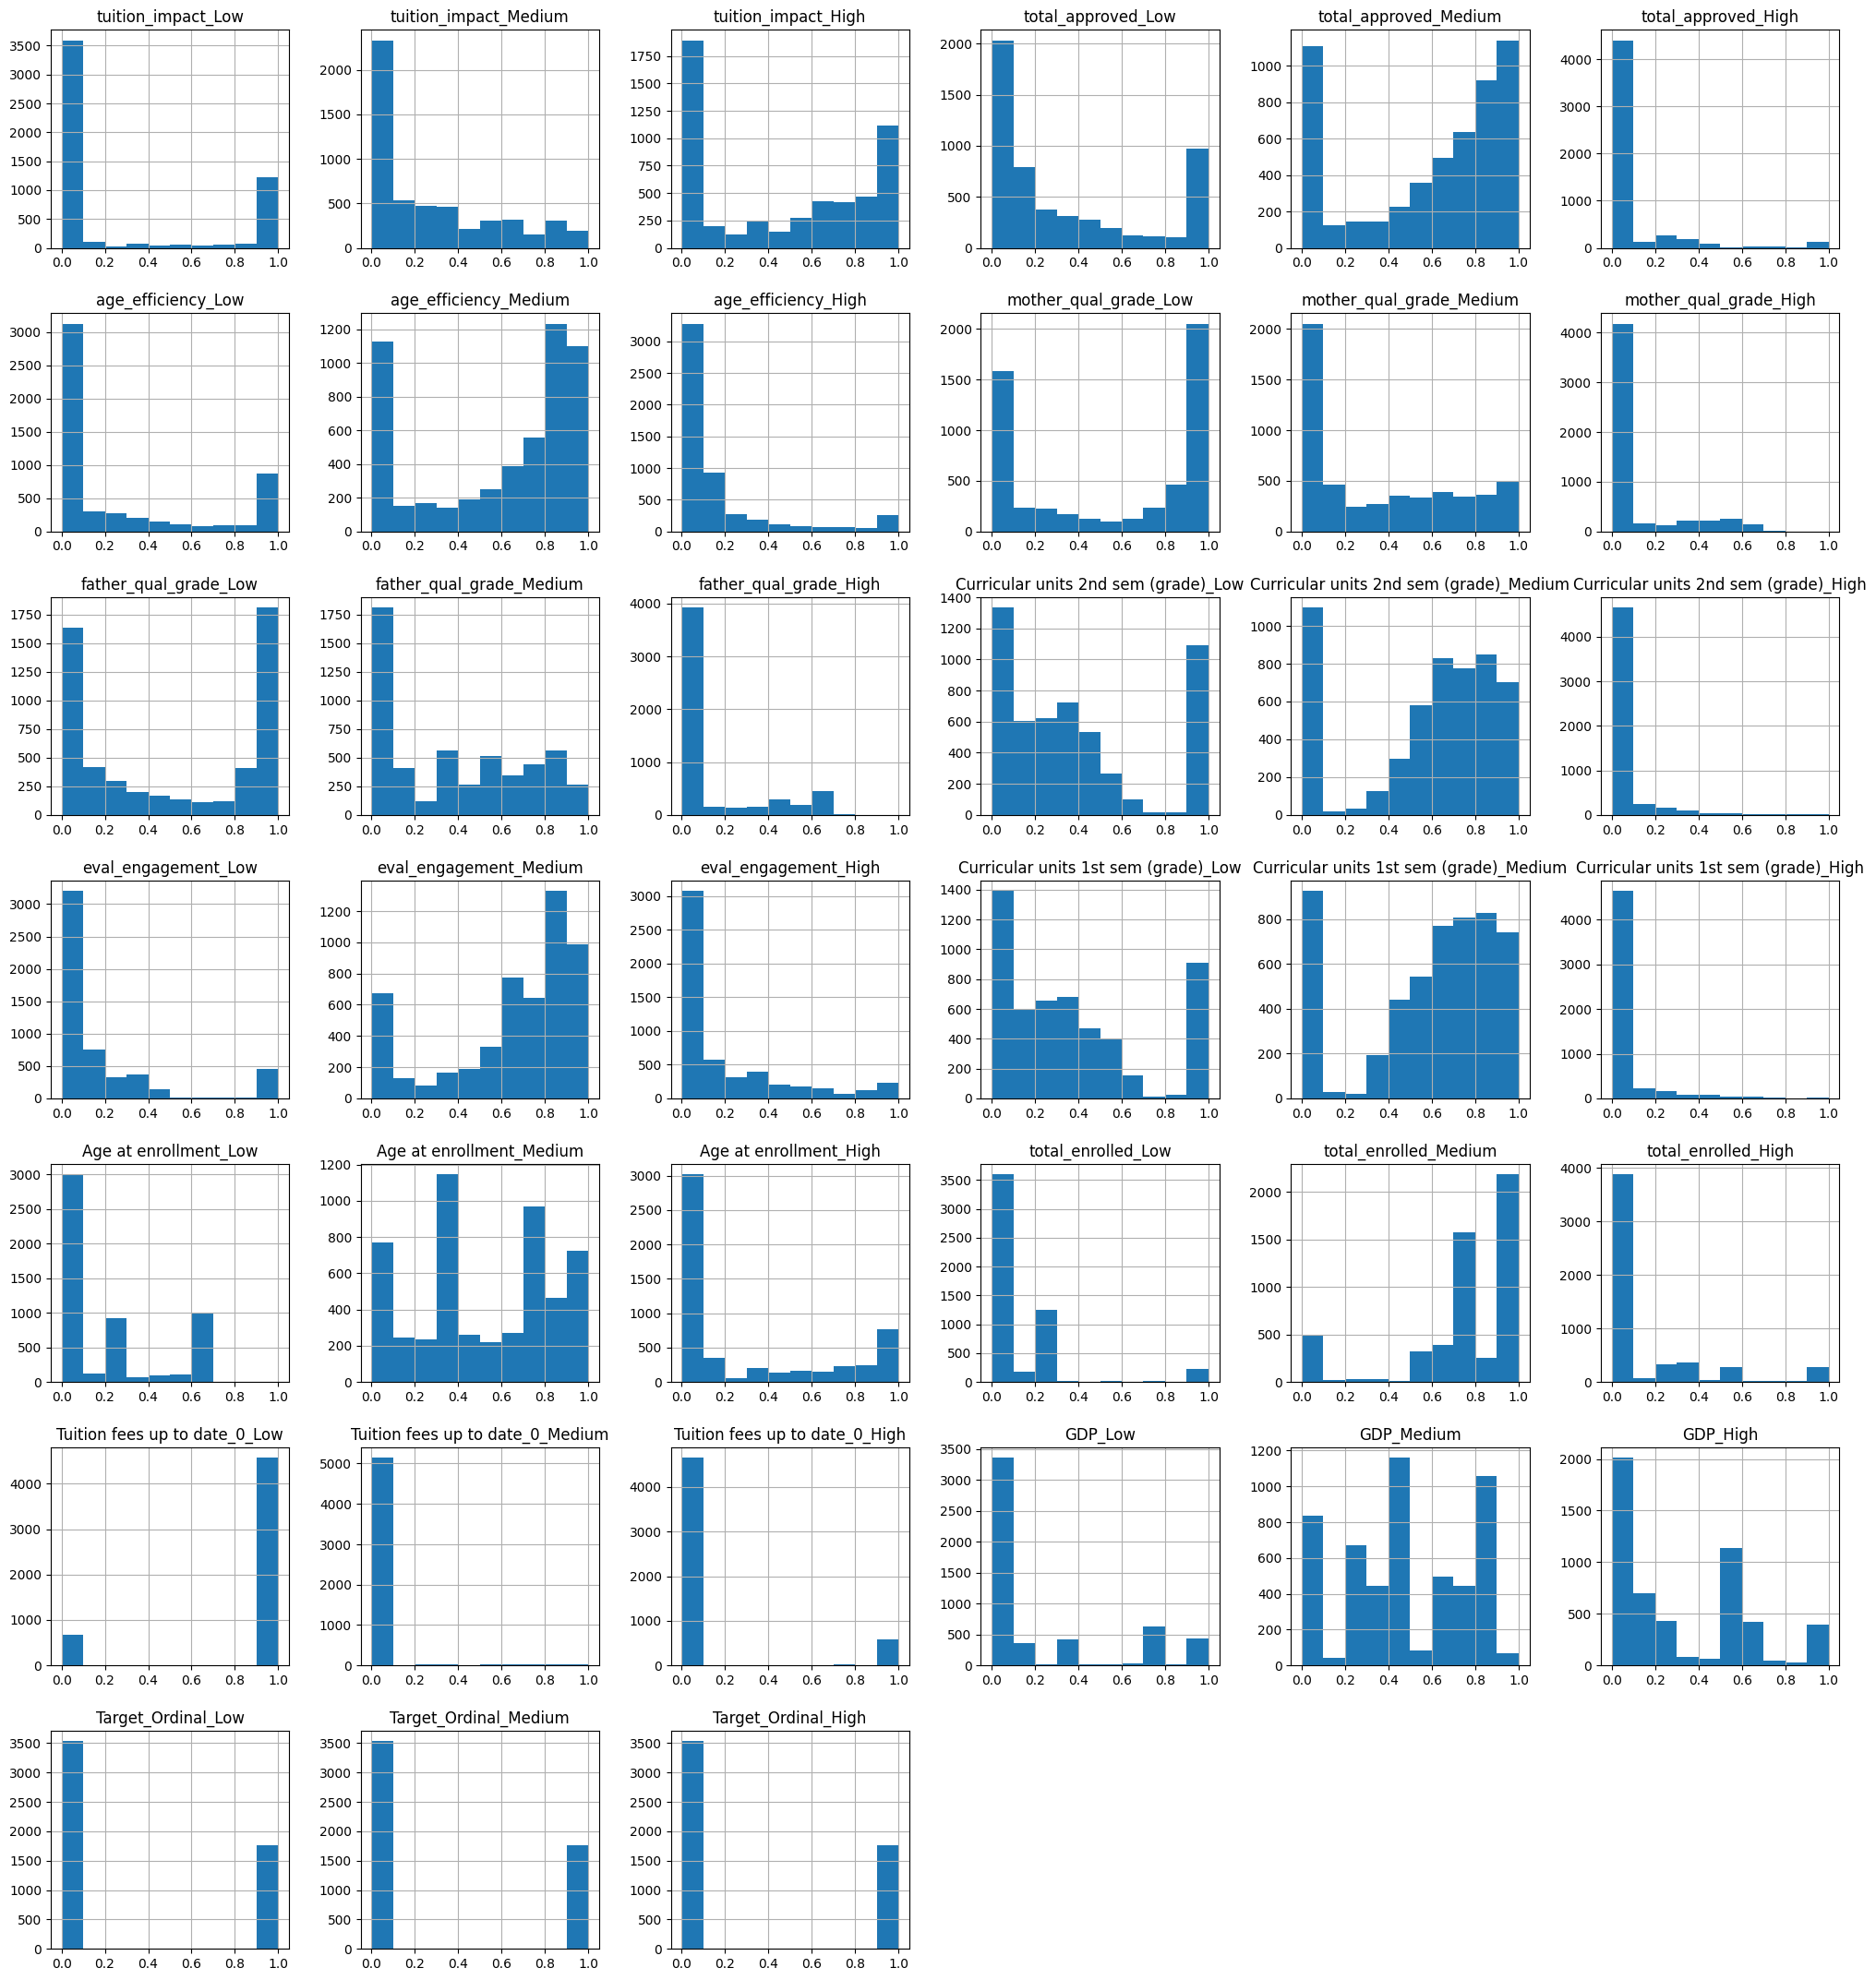

In [22]:
memberships_train.hist(figsize=(25,27))
plt.show()

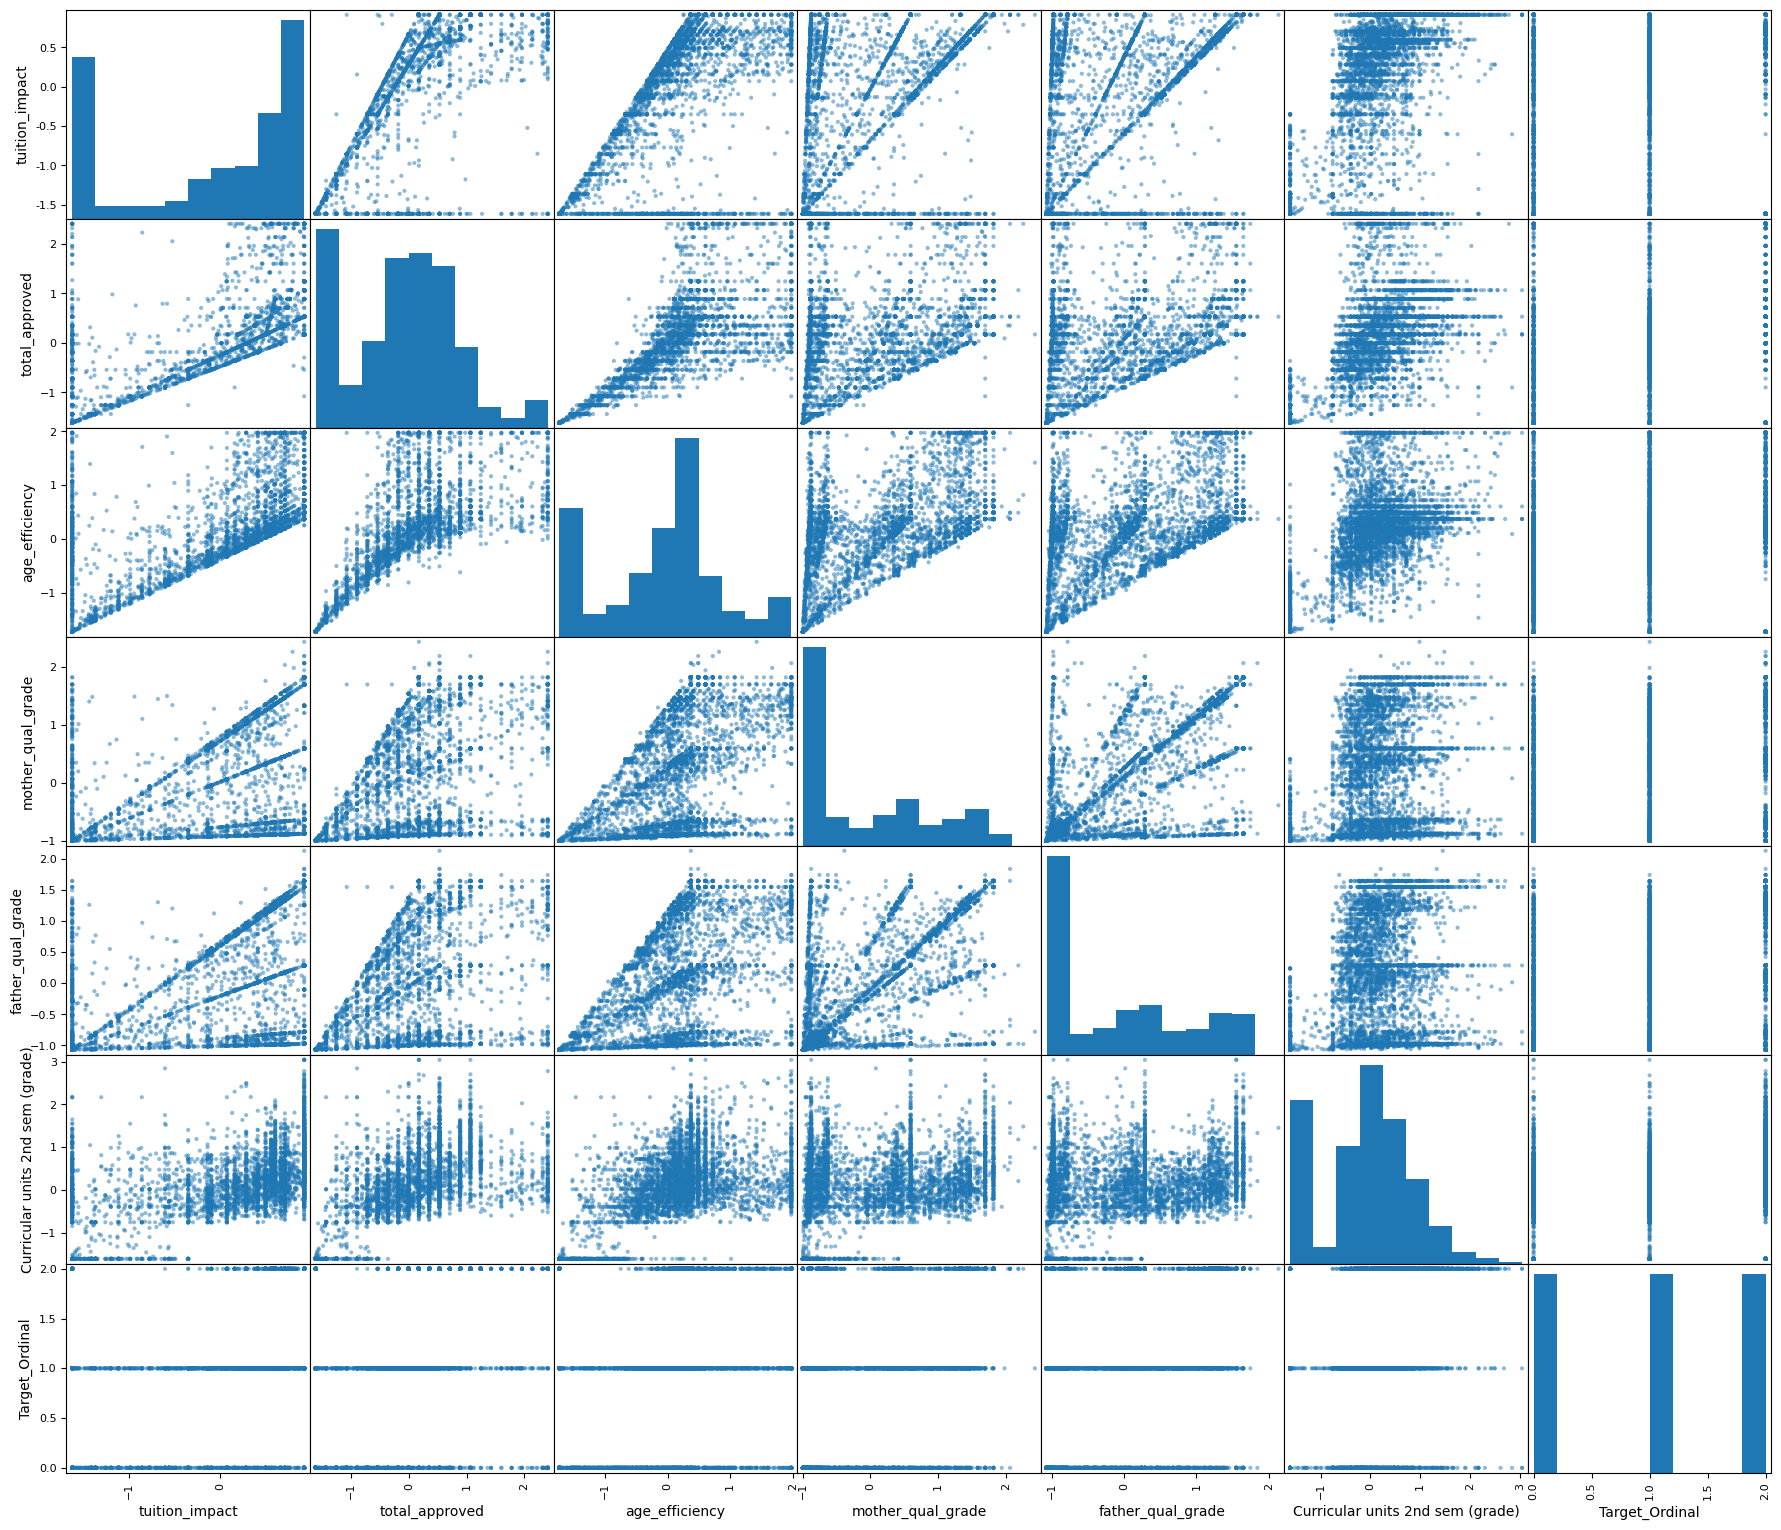

In [23]:
scatter_matrix(train_set_processed[top_features[:6] + ["Target_Ordinal"]], figsize=(22, 19))
plt.show()

## Fuzzy Rule Mining via Wang-Mendel Algorithm

In [24]:
def generate_wang_mendel_rules(df: pd.DataFrame, fuzzy_features: list, target_col: str):
    """
    Generate candidate fuzzy IF-THEN rules using Wang-Mendel method.

    Args:
        df: DataFrame with fuzzy memberships and fuzzy labels.
        fuzzy_features: list of feature names (without suffixes).
        target_col: target column name ("Target").

    Returns:
        List of tuples (antecedents, consequent, weight)
    """
    rules = []

    for idx, row in df.iterrows():
        antecedents = []
        degrees = []


        for feature in fuzzy_features:
            label = row[f"{feature}_fuzzy_label"]
            membership_degree = row[f"{feature}_is_{label}"] if label in ['0', '1'] else row[f"{feature}_{label}"]

            antecedents.append((feature, label))
            degrees.append(membership_degree)

        consequent = row[f"{target_col}_fuzzy_label"]


        # print(degrees)

        weight = np.min(degrees)

        rules.append((antecedents, consequent, weight))

    return rules


def prune_rules(rules):
    """
    Keep only the highest-weight rule per unique antecedent.

    Args:
        rules: List of (antecedents, consequent, weight)

    Returns:
        Pruned list of rules
    """
    antecedent_groups = {}

    for antecedents, consequent, weight in rules:
        antecedents_key = tuple(antecedents)

        if antecedents_key not in antecedent_groups:
            antecedent_groups[antecedents_key] = (consequent, weight)

        else:
            # Keep rule with higher weight
            if weight > antecedent_groups[antecedents_key][1]:
                antecedent_groups[antecedents_key] = (consequent, weight)

    pruned_rules = []
    for antecedents_key, (consequent, weight) in antecedent_groups.items():
        pruned_rules.append((antecedents_key, consequent, weight))

    return pruned_rules



target_col = "Target_Ordinal"

wang_mendel_rules = generate_wang_mendel_rules(memberships_train, top_features, target_col)
pruned_rules = prune_rules(wang_mendel_rules)

print(f"n rules: {len(pruned_rules)}")
print("Top 5 rules:")
for antecedents, consequent, weight in sorted(pruned_rules, key=lambda x: x[2], reverse=True)[:5]:
    rule_text = " AND ".join([f"{feat} IS {label}" for feat, label in antecedents])
    print(f"IF {rule_text} THEN {consequent} [weight={weight:.4f}]")

n rules: 1064
Top 5 rules:
IF tuition_impact IS Low AND total_approved IS Low AND age_efficiency IS Low AND mother_qual_grade IS Low AND father_qual_grade IS Low AND Curricular units 2nd sem (grade) IS Low AND eval_engagement IS Low AND Curricular units 1st sem (grade) IS Low AND Age at enrollment IS Low AND total_enrolled IS Low AND Tuition fees up to date_0 IS Low AND GDP IS Low THEN Medium [weight=1.0000]
IF tuition_impact IS Low AND total_approved IS Low AND age_efficiency IS Low AND mother_qual_grade IS Low AND father_qual_grade IS Low AND Curricular units 2nd sem (grade) IS Low AND eval_engagement IS Low AND Curricular units 1st sem (grade) IS Low AND Age at enrollment IS High AND total_enrolled IS Medium AND Tuition fees up to date_0 IS Low AND GDP IS Low THEN Low [weight=1.0000]
IF tuition_impact IS Low AND total_approved IS Low AND age_efficiency IS Low AND mother_qual_grade IS Low AND father_qual_grade IS Low AND Curricular units 2nd sem (grade) IS Low AND eval_engagement IS 

## Genetic Algorithm-Based Rule Optimization

In [25]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score

class FIS:
    def __init__(self, rule_base, fuzzy_df, target_col, label_encoder=None, inference=False):
        self.label_encoder = label_encoder

        if not label_encoder:
          self.label_encoder = LabelEncoder()

        self.fuzzy_df = fuzzy_df
        if not inference:
          self.y_true = self.label_encoder.fit_transform(fuzzy_df[target_col])

        else:
          self.y_true = self.label_encoder.transform(fuzzy_df[target_col])

        self.majority_class = np.bincount(self.y_true).argmax()

        self.rule_base = rule_base
        self.n_rules = len(rule_base)

        self.rule_fires = np.empty((self.n_rules, len(fuzzy_df)), dtype=bool)   # boolean mat, which rules fire for each data point?
        self.firing_degrees = np.empty_like(self.rule_fires, dtype=float)    # how much each rule fires for each data point
        self.rule_weights = np.empty(self.n_rules)
        self.rule_consequents = np.empty(self.n_rules, dtype=int)    # labels

        self.compute_inference_matrices()


    def compute_inference_matrices(self):
      for i, (ants, consq, weight) in enumerate(self.rule_base):    # for each rule in the base
        # check this rule against all data points
        fire_bool = np.ones(len(self.fuzzy_df), dtype=bool)
        fire_degree = np.ones(len(self.fuzzy_df), dtype=float)

        # for each feature in ants
        for feat, lbl in ants:
          col = f"{feat}_is_{lbl}" if lbl in ['0', '1'] else f"{feat}_{lbl}"
          fire_bool = fire_bool & (self.fuzzy_df[f"{feat}_fuzzy_label"] == lbl)
          fire_degree = np.minimum(fire_degree, self.fuzzy_df[col].values)

        self.rule_fires[i] = fire_bool
        self.firing_degrees[i] = fire_degree
        self.rule_weights[i] = weight
        self.rule_consequents[i] = self.label_encoder.transform([consq])[0]

      # normalize weights to [0, 1]
      self.rule_weights = (self.rule_weights - self.rule_weights.min()) / (self.rule_weights.max() - self.rule_weights.min() + 1e-6)

    def predict(self, selected_rules_mask=None):
      if selected_rules_mask is None:
        selected_rules_mask = np.ones(self.n_rules, dtype=bool)
        print("Warning: using all the rules.")

      assert len(selected_rules_mask) == self.n_rules

      selected_rules_mask = selected_rules_mask.astype(bool)

      # If no rules is selected
      # return the majority class
      if not selected_rules_mask.any():
        return np.full_like(self.y_true, self.majority_class), (self.majority_class == self.y_true).mean()

      rule_weights_selected = self.rule_weights[selected_rules_mask][:, None]
      firing_degrees_selected = self.firing_degrees[selected_rules_mask]

      weighted_firing_degrees = firing_degrees_selected * rule_weights_selected

      predicted_classes = self.rule_consequents[selected_rules_mask][np.argmax(weighted_firing_degrees, axis=0)]
      accuracy = (predicted_classes == self.y_true).mean()

      return predicted_classes, accuracy

    def evaluate(self, selected_rules_mask=None):
      if selected_rules_mask is None:
        selected_rules_mask = np.ones(self.n_rules, dtype=bool)
        print("Warning: using all the rules.")

      assert len(selected_rules_mask) == self.n_rules

      predicted_classes, _ = self.predict(selected_rules_mask)

      cm = confusion_matrix(self.y_true, predicted_classes)
      acc = accuracy_score(self.y_true, predicted_classes)
      f1 = f1_score(self.y_true, predicted_classes, average='macro')
      precision = precision_score(self.y_true, predicted_classes, average='macro')
      recall = recall_score(self.y_true, predicted_classes, average='macro')

        # Return all metrics as a dictionary
      return {
          "confusion_matrix": cm,
          "accuracy": acc,
          "f1_score": f1,
          "precision": precision,
          "recall": recall}

[22:21:56] gen   5 acc=0.6431  k=204/500  pen=0.194  net=0.5183
[22:22:08] gen  10 acc=0.6497  k=194/500  pen=0.184  net=0.5301
[22:22:19] gen  15 acc=0.6714  k=202/500  pen=0.192  net=0.5425
[22:22:34] gen  20 acc=0.6861  k=191/500  pen=0.181  net=0.5619
[22:22:46] gen  25 acc=0.6838  k=187/500  pen=0.177  net=0.5628
[22:22:57] gen  30 acc=0.6838  k=187/500  pen=0.177  net=0.5628
[22:23:09] gen  35 acc=0.6848  k=184/500  pen=0.174  net=0.5656
[22:23:20] gen  40 acc=0.6850  k=182/500  pen=0.172  net=0.5672
[22:23:32] gen  45 acc=0.6870  k=177/500  pen=0.167  net=0.5723
[22:23:44] gen  50 acc=0.6912  k=182/500  pen=0.172  net=0.5723
[22:24:05] gen  55 acc=0.6829  k=166/500  pen=0.156  net=0.5764
[22:24:24] gen  60 acc=0.6874  k=167/500  pen=0.157  net=0.5795
[22:24:36] gen  65 acc=0.6874  k=167/500  pen=0.157  net=0.5795
[22:24:47] gen  70 acc=0.6952  k=172/500  pen=0.162  net=0.5825
[22:24:59] gen  75 acc=0.6942  k=167/500  pen=0.157  net=0.5852
[22:25:09] gen  80 acc=0.6970  k=163/500

/usr/local/lib/python3.11/dist-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


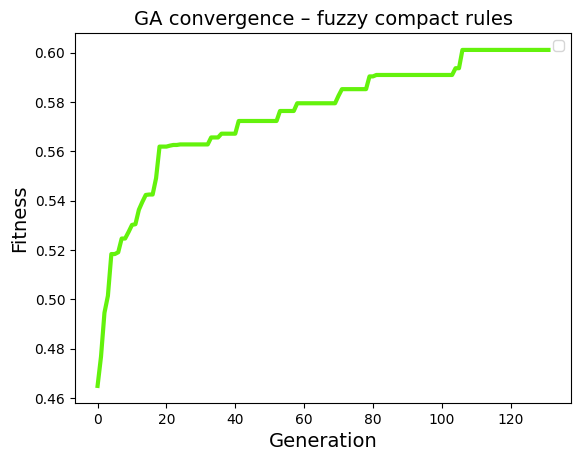


   Selected 155 / 500 rules
   train metrics = 
   Accuracy: 0.7031
   F1 Score: 0.7015
   Precision: 0.7021
   Recall: 0.7031
   Confusion Matrix:
[[1375  113  279]
 [ 186 1299  282]
 [ 403  311 1053]]


In [26]:
from sklearn.preprocessing import LabelEncoder

MAX_N_RULES = 500
POP_SIZE      = 160
GENERATIONS   = 300
PARENTS       = 50
MUT_PROB      = 0.05
ALPHA         = 0.5
SAFE_MARGIN   = 0.02
PROG_EVERY    = 5

rule_base = sorted(pruned_rules, key=lambda r: r[2], reverse=True)[:MAX_N_RULES]

train_FIS = FIS(rule_base, memberships_train, "Target_Ordinal_fuzzy_label")


def fuzzy_fitness(selected_rules_mask, alpha=ALPHA, margin=SAFE_MARGIN):
    preds, acc = train_FIS.predict(selected_rules_mask)

    rule_overuse_penalty = max(0.0, selected_rules_mask.mean() - margin)

    return acc * (1.0 - alpha * rule_overuse_penalty)


def fitness_func(ga, sol, _):
    return fuzzy_fitness(np.asarray(sol, int))


def on_gen(ga):
    if ga.generations_completed % PROG_EVERY == 0:
        sol, net, _ = ga.best_solution()
        mask = np.asarray(sol, int)
        acc = fuzzy_fitness(mask, alpha=0)
        k = mask.sum()
        pen = max(0.0, mask.mean() - SAFE_MARGIN) * ALPHA
        print(f"[{time.strftime('%H:%M:%S')}] gen {ga.generations_completed:3d} "
              f"acc={acc:.4f}  k={k}/{train_FIS.n_rules}  pen={pen:.3f}  net={net:.4f}")


def run_ga():
    ga = pygad.GA(num_generations       = GENERATIONS,
                  sol_per_pop           = POP_SIZE,
                  num_parents_mating    = PARENTS,
                  num_genes             = train_FIS.n_rules,
                  gene_space            = [0, 1],
                  parent_selection_type = "tournament", K_tournament=6,
                  keep_elitism          = POP_SIZE // 10,
                  crossover_type        = "two_points",
                  mutation_type         = "random",
                  mutation_probability  = MUT_PROB,
                  mutation_by_replacement= True,
                  fitness_func          = fitness_func,
                  on_generation         = on_gen,
                  parallel_processing   = ("process", mp.cpu_count()),
                  stop_criteria         = ["saturate_25"],
                  random_seed=SEED)

    start_time = time.time()
    ga.run()
    print(f"GA runtime: {time.time() - start_time} seconds")

    ga.plot_fitness(title="GA convergence – fuzzy compact rules")

    return ga


def output_best_rules(ga, rule_base):
    n_rules = len(rule_base)
    best_sol, best_fit, _ = ga.best_solution()
    mask = np.asarray(best_sol, int)
    sel_rules = [r for r, keep in zip(rule_base, mask) if keep]
    train_metrics = train_FIS.evaluate(mask)

    print(f"\n   Selected {len(sel_rules)} / {n_rules} rules"
          f"\n   train metrics = ")
    print(f"   Accuracy: {train_metrics['accuracy']:.4f}")
    print(f"   F1 Score: {train_metrics['f1_score']:.4f}")
    print(f"   Precision: {train_metrics['precision']:.4f}")
    print(f"   Recall: {train_metrics['recall']:.4f}")
    print(f"   Confusion Matrix:\n{train_metrics['confusion_matrix']}")

    return sel_rules, best_sol



ga = run_ga()
selected_rules, best_sol = output_best_rules(ga, rule_base)

In [27]:
for i, (ants, cons, w) in enumerate(selected_rules, 1):
    antecedent = " AND ".join([f"{f} IS {l}" for f, l in ants])
    print(f"{i:02d}) IF {antecedent} → THEN {cons}  (w={w:.3f})")

01) IF tuition_impact IS Low AND total_approved IS Low AND age_efficiency IS Low AND mother_qual_grade IS Low AND father_qual_grade IS Low AND Curricular units 2nd sem (grade) IS Low AND eval_engagement IS Low AND Curricular units 1st sem (grade) IS Low AND Age at enrollment IS High AND total_enrolled IS Medium AND Tuition fees up to date_0 IS Medium AND GDP IS Low → THEN Low  (w=0.981)
02) IF tuition_impact IS Low AND total_approved IS Low AND age_efficiency IS Low AND mother_qual_grade IS Low AND father_qual_grade IS Low AND Curricular units 2nd sem (grade) IS Low AND eval_engagement IS Low AND Curricular units 1st sem (grade) IS Low AND Age at enrollment IS Medium AND total_enrolled IS Low AND Tuition fees up to date_0 IS Low AND GDP IS Low → THEN Low  (w=0.953)
03) IF tuition_impact IS Low AND total_approved IS Low AND age_efficiency IS Low AND mother_qual_grade IS Low AND father_qual_grade IS Low AND Curricular units 2nd sem (grade) IS Low AND eval_engagement IS Low AND Curricular

## Fuzzy Inference System Evaluation

In [28]:
test_FIS = FIS(selected_rules, memberships_test, "Target_Ordinal_fuzzy_label", label_encoder=train_FIS.label_encoder, inference=True)
test_metrics = test_FIS.evaluate()

print("Test metrics:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"Confusion Matrix:\n{test_metrics['confusion_matrix']}")

Test metrics:
Accuracy: 0.6983
F1 Score: 0.6501
Precision: 0.6492
Recall: 0.6548
Confusion Matrix:
[[331  27  84]
 [ 34 213  37]
 [ 45  40  74]]


In [29]:
preds, _ = test_FIS.predict()

<Axes: >

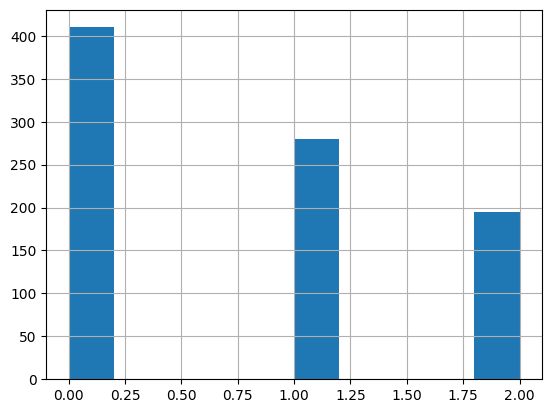

In [30]:
pd.Series(preds).hist()

## Advanced System Visualization

<Figure size 1600x1400 with 0 Axes>

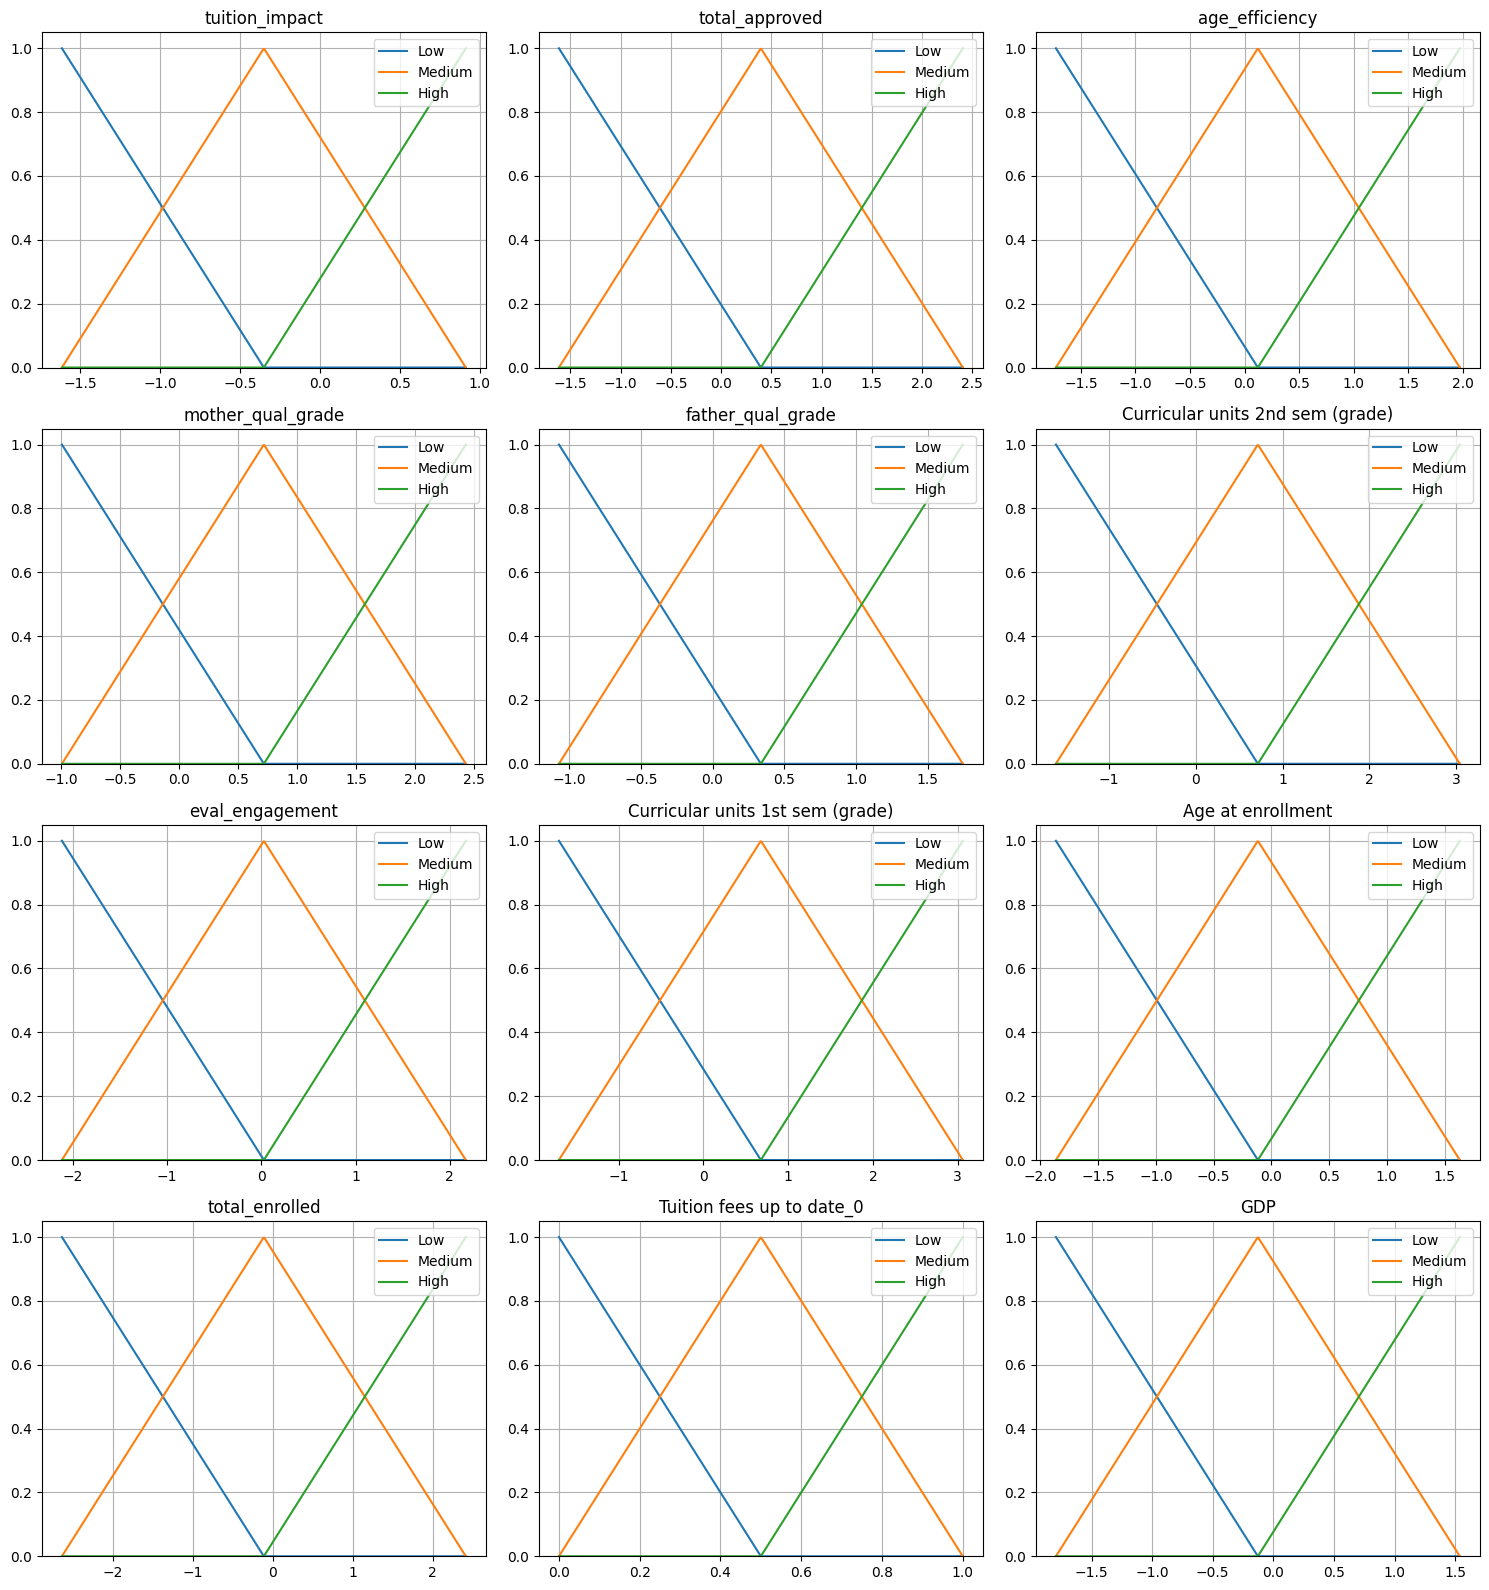

In [31]:
# 1. Visualize membership functions
plt.figure(figsize=(16, 14))
plot_membership_grid(test_set_processed, top_features[::], max_cols=3)



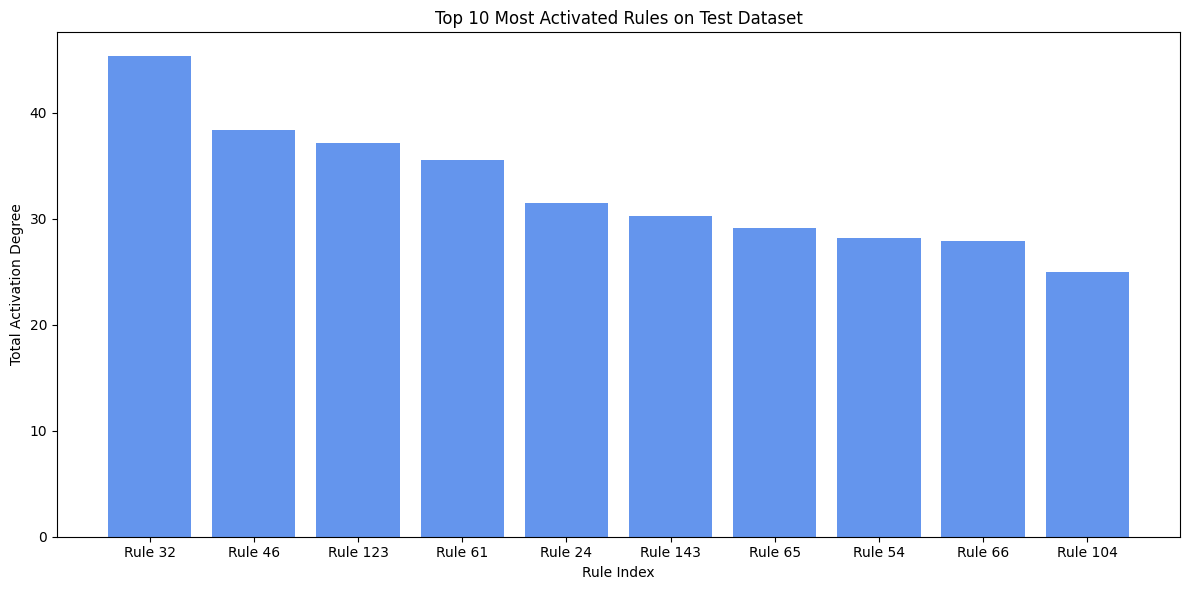

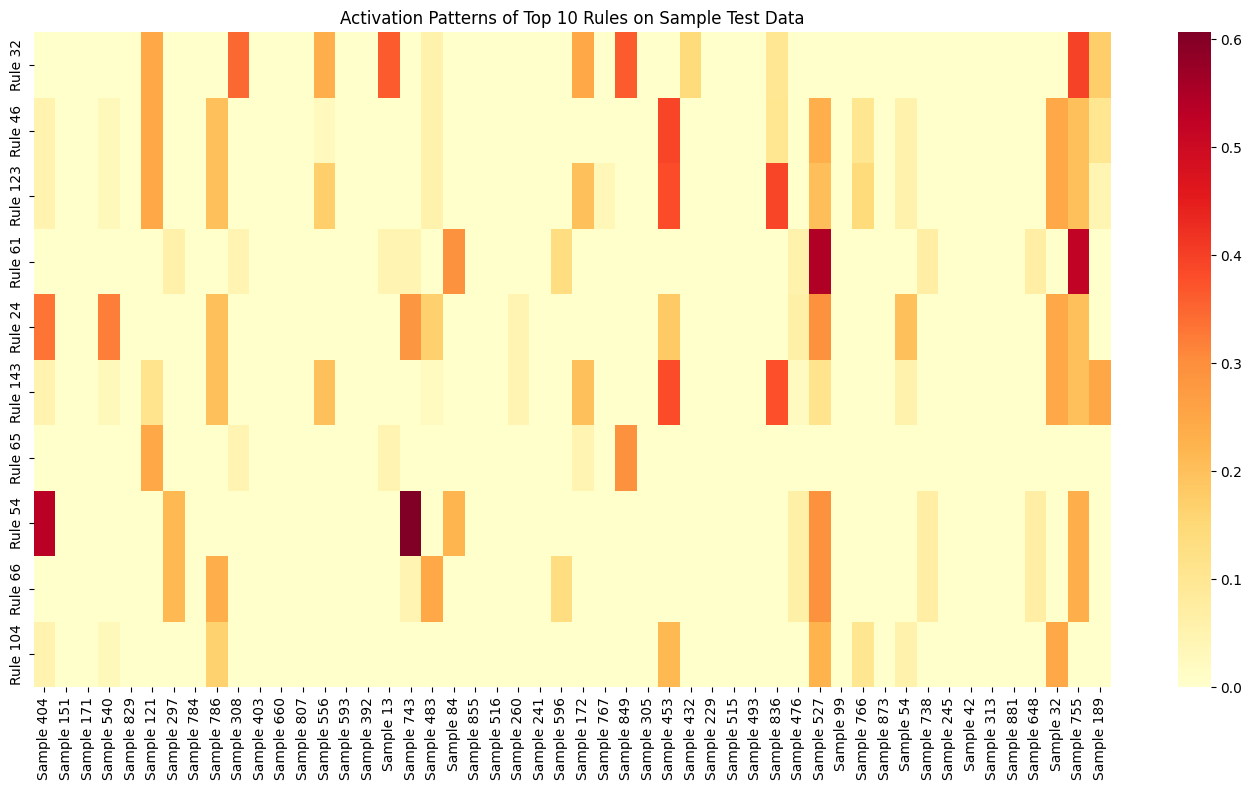

Key Fuzzy Rules by Activation Level:
1. Rule 32: IF tuition_impact IS High AND total_approved IS Medium AND age_efficiency IS Medium AND mother_qual_grade IS High AND father_qual_grade IS Medium AND Curricular units 2nd sem (grade) IS Medium AND eval_engagement IS Medium AND Curricular units 1st sem (grade) IS Medium AND Age at enrollment IS Medium AND total_enrolled IS Medium AND Tuition fees up to date_0 IS Low AND GDP IS Medium THEN High (Total Activation: 45.34)
2. Rule 46: IF tuition_impact IS Medium AND total_approved IS Medium AND age_efficiency IS Medium AND mother_qual_grade IS Medium AND father_qual_grade IS Medium AND Curricular units 2nd sem (grade) IS Medium AND eval_engagement IS Medium AND Curricular units 1st sem (grade) IS Low AND Age at enrollment IS Medium AND total_enrolled IS Medium AND Tuition fees up to date_0 IS Low AND GDP IS Medium THEN Medium (Total Activation: 38.40)
3. Rule 123: IF tuition_impact IS Medium AND total_approved IS Medium AND age_efficiency IS 

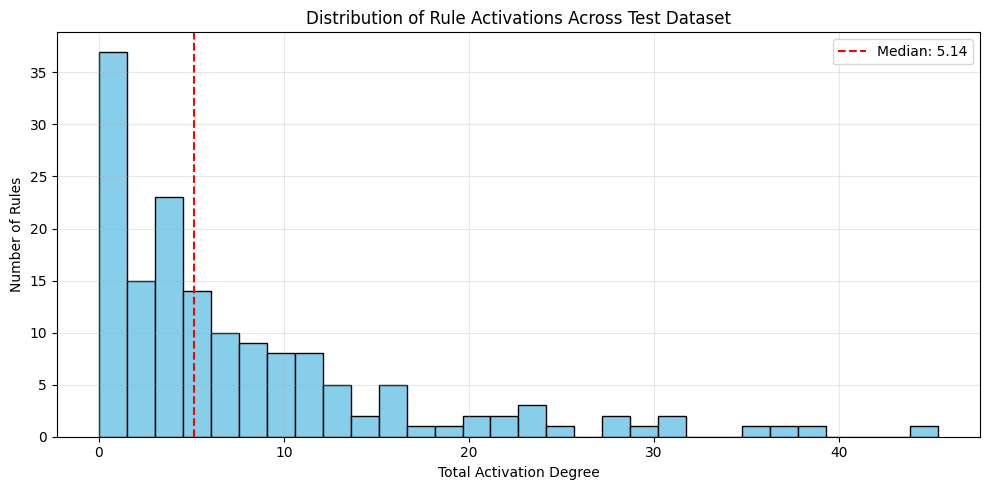

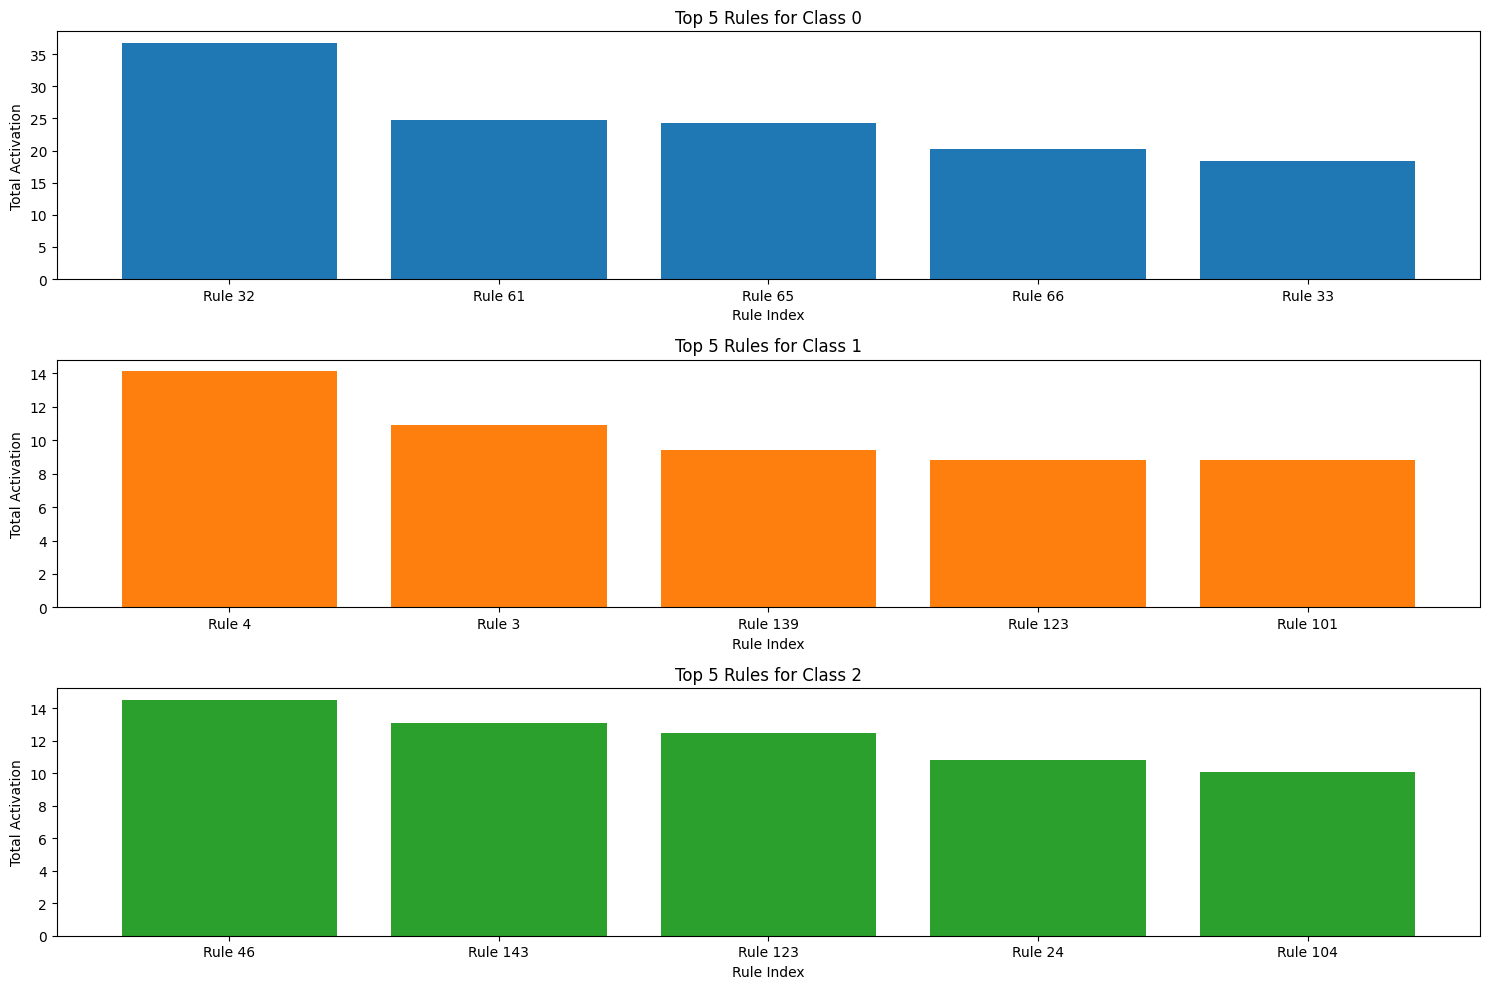

In [32]:
# Calculate total rule activations across all test samples
rule_total_activation = test_FIS.firing_degrees.sum(axis=1)
rule_normalized_activation = rule_total_activation / len(test_FIS.fuzzy_df)

# Find top 10 most activated rules
top_rule_indices = np.argsort(rule_total_activation)[-10:][::-1]
top_rule_activations = rule_total_activation[top_rule_indices]

# Visualize top 10 rules by activation degree
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_rule_indices)), top_rule_activations, color='cornflowerblue')
plt.xlabel('Rule Index')
plt.ylabel('Total Activation Degree')
plt.title('Top 10 Most Activated Rules on Test Dataset')
plt.xticks(range(len(top_rule_indices)), [f"Rule {idx}" for idx in top_rule_indices])
plt.tight_layout()
plt.show()

# Create heatmap of rule activation patterns
plt.figure(figsize=(14, 8))
# Select top 10 rules and a sample of 50 test instances for visualization
sample_indices = np.random.choice(test_FIS.firing_degrees.shape[1], min(50, test_FIS.firing_degrees.shape[1]), replace=False)
activation_heatmap = test_FIS.firing_degrees[top_rule_indices][:, sample_indices]

sns.heatmap(activation_heatmap, cmap="YlOrRd",
            xticklabels=[f"Sample {i}" for i in sample_indices],  # Show every 5th label
            yticklabels=[f"Rule {i}" for i in top_rule_indices])
plt.title("Activation Patterns of Top 10 Rules on Sample Test Data")
plt.tight_layout()
plt.show()

# Display the key rules with their antecedents and consequents
print("Key Fuzzy Rules by Activation Level:")
for i, rule_idx in enumerate(top_rule_indices):
    if rule_idx < len(test_FIS.rule_base):
        ants, cons, w = test_FIS.rule_base[rule_idx]
        rule_text = " AND ".join([f"{f} IS {l}" for f, l in ants])
        print(f"{i+1}. Rule {rule_idx}: IF {rule_text} THEN {cons} (Total Activation: {rule_total_activation[rule_idx]:.2f})")

# Show activation distribution across all rules
plt.figure(figsize=(10, 5))
plt.hist(rule_total_activation, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=np.median(rule_total_activation), color='red', linestyle='--', label=f'Median: {np.median(rule_total_activation):.2f}')
plt.xlabel('Total Activation Degree')
plt.ylabel('Number of Rules')
plt.title('Distribution of Rule Activations Across Test Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Class-specific rule activation
y_test_classes = test_FIS.y_true
class_specific_activations = []

for class_idx in range(3):  # Assuming 3 classes
    class_mask = (y_test_classes == class_idx)
    if np.any(class_mask):
        class_activations = test_FIS.firing_degrees[:, class_mask].sum(axis=1)
        class_specific_activations.append((class_idx, class_activations))

# Plot top rules for each class
plt.figure(figsize=(15, 10))
for i, (class_idx, activations) in enumerate(class_specific_activations):
    top_indices = np.argsort(activations)[-5:][::-1]

    plt.subplot(len(class_specific_activations), 1, i+1)
    plt.bar(range(len(top_indices)), activations[top_indices], color=f'C{i}')
    plt.title(f'Top 5 Rules for Class {class_idx}')
    plt.xlabel('Rule Index')
    plt.ylabel('Total Activation')
    plt.xticks(range(len(top_indices)), [f"Rule {idx}" for idx in top_indices])

plt.tight_layout()
plt.show()

## Interactive Prediction Interface

In [33]:
def end_to_end_predictor(ds: pd.DataFrame):
  mapping = {"Low": 0, "Medium": 1, "High": 2}

  ds_processed, X, Y = preprocess_pipeline(ds, is_test=True)
  ds_fuzzified = fuzzifier.transform(ds_processed)
  my_FIS = FIS(selected_rules, ds_fuzzified, "Target_Ordinal_fuzzy_label", label_encoder=train_FIS.label_encoder, inference=True)
  preds, _ = my_FIS.predict()
  ordinal_encoder = final_pipeline.named_steps['preprocessing'].named_transformers_['target'].named_steps['ordinal']
  preds = my_FIS.label_encoder.inverse_transform(preds)
  preds = np.array([[mapping[p]] for p in preds])
  preds = ordinal_encoder.inverse_transform(preds).flatten()
  return preds


In [34]:
top_features

['tuition_impact',
 'total_approved',
 'age_efficiency',
 'mother_qual_grade',
 'father_qual_grade',
 'Curricular units 2nd sem (grade)',
 'eval_engagement',
 'Curricular units 1st sem (grade)',
 'Age at enrollment',
 'total_enrolled',
 'Tuition fees up to date_0',
 'GDP']

In [35]:
test_set.iloc[25].to_frame().T.copy().info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 2002 to 2002
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   Marital status                                  1 non-null      object
 1   Application mode                                1 non-null      object
 2   Application order                               1 non-null      object
 3   Course                                          1 non-null      object
 4   Daytime/evening attendance                      1 non-null      object
 5   Previous qualification                          1 non-null      object
 6   Nacionality                                     1 non-null      object
 7   Mother's qualification                          1 non-null      object
 8   Father's qualification                          1 non-null      object
 9   Mother's occupation                             1 non-nul

In [36]:
# categories from https://github.com/carmelh/SQL_projects/blob/main/student_data_analysis/Datasets/tA1_marital_status.csv
# code by gpt 4o

import gradio as gr
import pandas as pd

# Define the list of features that are needed for generating engineered features
features = [
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)",
    "Mother's qualification",
    "Father's qualification",
    "Tuition fees up to date",
    "Scholarship holder",
    "Age at enrollment",
    "Gender"  # Ensure Gender is listed in features
]

# Mapping for categorical values (e.g., Mother's and Father's qualifications, Gender)
qualification_map = {
    'Secondary Education—12th Year of Schooling or Equivalent': 1,
    'Higher Education—bachelor’s degree': 2,
    'Higher Education—degree': 3,
    'Higher Education—master’s degree': 4,
    'Higher Education—doctorate': 5,
    'Frequency of Higher Education': 6,
    '12th Year of Schooling—not completed': 7,
    '11th Year of Schooling—not completed': 8,
    '7th Year (Old)': 9,
    'Other—11th Year of Schooling': 10,
    '2nd year complementary high school course': 11,
    '10th Year of Schooling': 12,
    'General commerce course': 13,
    'Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent': 14,
    'Complementary High School Course': 15,
    'Technical-professional course': 16,
    'Complementary High School Course—not concluded': 17,
    '7th year of schooling': 18,
    '2nd cycle of the general high school course': 19,
    '9th Year of Schooling—not completed': 20,
    '8th year of schooling': 21,
    'General Course of Administration and Commerce': 22,
    'Supplementary Accounting and Administration': 23,
    'Unknown': 24,
    'Cannot read or write': 25,
    'Can read without having a 4th year of schooling': 26,
    'Basic education 1st cycle (4th/5th year) or equivalent': 27,
    'Basic Education 2nd Cycle (6th/7th/8th Year) or equivalent': 28,
    'Technological specialization course': 29,
    'Higher education—degree (1st cycle)': 30,
    'Specialized higher studies course': 31,
    'Professional higher technical course': 32,
    'Higher Education—master’s degree (2nd cycle)': 33,
    'Higher Education—doctorate (3rd cycle)': 34
}

gender_map = {
    'Female': 0,
    'Male': 1
}

# Dummy values for the features not provided by the user
dummy_values = {
    'Marital status': 1,
    'Application mode': 8,
    'Application order': 5,
    'Course': 2,
    'Daytime/evening attendance': 1,
    'Previous qualification': 1,
    'Nacionality': 1,
    'Mother\'s occupation': 6,
    'Father\'s occupation': 6,
    'Displaced': 0,
    'Educational special needs': 0,
    'Debtor': 0,
    'International': 0,
    'Curricular units 1st sem (credited)': 0,
    'Curricular units 1st sem (without evaluations)': 0,
    'Curricular units 2nd sem (credited)': 0,
    'Curricular units 2nd sem (without evaluations)': 0,
    'Curricular units 1st sem (evaluations)': 0,
    'Curricular units 2nd sem (evaluations)': 0,
    'Unemployment rate': 0.0,
    'Inflation rate': 0.0,
    'GDP': 0.0,
    'Gender': 0,  # Added default value for 'Gender'
    'Target': 'Dropout'
}

# Define the categorical options for the dropdown menus
categorical_options = {
    "Mother's qualification": ['Secondary Education—12th Year of Schooling or Equivalent', 'Higher Education—bachelor’s degree', 'Higher Education—degree',
                               'Higher Education—master’s degree', 'Higher Education—doctorate', 'Frequency of Higher Education', '12th Year of Schooling—not completed',
                               '11th Year of Schooling—not completed', '7th Year (Old)', 'Other—11th Year of Schooling', '2nd year complementary high school course',
                               '10th Year of Schooling', 'General commerce course', 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent', 'Complementary High School Course',
                               'Technical-professional course', 'Complementary High School Course—not concluded', '7th year of schooling', '2nd cycle of the general high school course',
                               '9th Year of Schooling—not completed', '8th year of schooling', 'General Course of Administration and Commerce', 'Supplementary Accounting and Administration',
                               'Unknown', 'Cannot read or write', 'Can read without having a 4th year of schooling', 'Basic education 1st cycle (4th/5th year) or equivalent',
                               'Basic Education 2nd Cycle (6th/7th/8th Year) or equivalent', 'Technological specialization course', 'Higher education—degree (1st cycle)',
                               'Specialized higher studies course', 'Professional higher technical course', 'Higher Education—master’s degree (2nd cycle)',
                               'Higher Education—doctorate (3rd cycle)'],
    "Father's qualification": ['Secondary Education—12th Year of Schooling or Equivalent', 'Higher Education—bachelor’s degree', 'Higher Education—degree',
                               'Higher Education—master’s degree', 'Higher Education—doctorate', 'Frequency of Higher Education', '12th Year of Schooling—not completed',
                               '11th Year of Schooling—not completed', '7th Year (Old)', 'Other—11th Year of Schooling', '2nd year complementary high school course',
                               '10th Year of Schooling', 'General commerce course', 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent', 'Complementary High School Course',
                               'Technical-professional course', 'Complementary High School Course—not concluded', '7th year of schooling', '2nd cycle of the general high school course',
                               '9th Year of Schooling—not completed', '8th year of schooling', 'General Course of Administration and Commerce', 'Supplementary Accounting and Administration',
                               'Unknown', 'Cannot read or write', 'Can read without having a 4th year of schooling', 'Basic education 1st cycle (4th/5th year) or equivalent',
                               'Basic Education 2nd Cycle (6th/7th/8th Year) or equivalent', 'Technological specialization course', 'Higher education—degree (1st cycle)',
                               'Specialized higher studies course', 'Professional higher technical course', 'Higher Education—master’s degree (2nd cycle)',
                               'Higher Education—doctorate (3rd cycle)'],
    'Gender': ['Female', 'Male'],
}

# Function to process the input and run prediction
def gradio_predict(*input_values):
    # Convert the inputs into a dictionary (mapping categorical features to numeric)
    user_input = dict(zip(features, input_values))

    a = test_set.iloc[25].to_frame().T.copy()

    # Convert categorical features to numeric values based on predefined maps
    if "Mother's qualification" in user_input:
        user_input["Mother's qualification"] = qualification_map.get(user_input["Mother's qualification"], 0)  # Default to 0 if not found
    if "Father's qualification" in user_input:
        user_input["Father's qualification"] = qualification_map.get(user_input["Father's qualification"], 0)  # Default to 0 if not found
    if "Gender" in user_input:
        user_input["Gender"] = gender_map.get(user_input["Gender"], 0)  # Default to 0 (Female) if not found

    # Create a full input dictionary with dummy values for missing features
    full_input = {**dummy_values, **user_input}

    # Convert the full input dictionary into a DataFrame
    input_data = pd.DataFrame([full_input])

    # Cast all columns to the correct type (ensure consistency between training and prediction)
    input_data = input_data.astype({
        'Age at enrollment': 'int64',
        'Curricular units 1st sem (approved)': 'int64',
        'Curricular units 1st sem (enrolled)': 'int64',
        'Curricular units 2nd sem (approved)': 'int64',
        'Curricular units 2nd sem (enrolled)': 'int64',
        'Curricular units 1st sem (grade)': 'float64',
        'Curricular units 2nd sem (grade)': 'float64',
        'Tuition fees up to date': 'int64',
        'Scholarship holder': 'int64',
        'Gender': 'int64',  # Ensure 'Gender' is treated as int
        'Target': 'object'
    })

    a[features] = input_data[features]
    print(a.to_numpy())
    # Call the prediction function (assuming you have the 'end_to_end_predictor' function)
    prediction = end_to_end_predictor(a)

    return prediction[0]

# Create Gradio inputs based on the features list
inputs = []
for feature in features:
    if feature in categorical_options:
        inputs.append(gr.Dropdown(label=feature, choices=categorical_options[feature]))
    elif feature in ['Age at enrollment']:
        inputs.append(gr.Number(label=feature, precision=2))
    elif feature in ['Tuition fees up to date', 'Scholarship holder']:
        inputs.append(gr.Checkbox(label=feature))
    else:
        inputs.append(gr.Number(label=feature))

# Add the Predict button
predict_button = gr.Button("Predict")

# Create the Gradio interface
gr.Interface(
    fn=gradio_predict,
    inputs=inputs + [predict_button],  # Add button as input
    outputs="text",
    live=False,  # Disable live updates; prediction happens only when button is clicked
    title="Student Dropout Prediction",
    description="Input the features to predict whether a student will drop out."
).launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a3c238e299887b0334.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a3c238e299887b0334.gradio.live
